In [1]:
import os.path
import math
%matplotlib inline

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.ticker import NullLocator
import numpy as np
from matplotlib.cm import ScalarMappable

##  This notebook attempts to analyze the effects of sigma and msigma for the DynamicERI cholesky decomposition algorithm for Au14 system

#### Define useful functions:

In [2]:
def set_shared_ylabel(a, ylabel, labelsize, labelpad = 0.01):
    """Set a y label shared by multiple axes
    Parameters
    ----------
    a: list of axes
    ylabel: string
    labelsize: integer
    labelpad: float
        Sets the padding between ticklabels and axis label"""

    f = a[0].get_figure()
    f.canvas.draw() #sets f.canvas.renderer needed below

    # get the center position for all plots
    top = a[0].get_position().y1
    bottom = a[-1].get_position().y0

    # get the coordinates of the left side of the tick labels 
    x0 = 1
    for at in a:
        at.set_ylabel('') # just to make sure we don't and up with multiple labels
        bboxes, _ = at.yaxis.get_ticklabel_extents(f.canvas.renderer)
        bboxes = bboxes.inverse_transformed(f.transFigure)
        xt = bboxes.x0
        if xt < x0:
            x0 = xt
    tick_label_left = x0

    # set position of label
    a[-1].set_ylabel(ylabel,fontsize=labelsize)
    a[-1].yaxis.set_label_coords(tick_label_left - labelpad,(bottom + top)/2, transform=f.transFigure)

In [3]:
# This function parses the output and returns two directionaries:

# dynamicERIProgress is a dictionary of lists that store the progress of each variable during CD
# dynamicERITotal is a dictionary of ints/floats that hold cumulataive data
def parseOutput(fname):

    if not os.path.exists(fname):
        return None
    f = open(fname)

    # dynamicERIProgress is a dictionary object that holds the step-by-step data obtained during the CD progress
    dynamicERIProgress = {}
    # dynamicERITotal is a dictionary object that holds cumulataive data
    dynamicERITotal = {}


    # Initialize the following keys for dynamicERIProgress to hold lists:

    # Pivot candidates. This corresponds to P in the paper
    dynamicERIProgress['D_size']= []

    # The current batch selected based on sigma and msigma. This corresponds to Q in the paper
    dynamicERIProgress['lenQ']= []

    # The number of computed ERI vectors (of length D) stored in memory. This corresponds to Epsilon in the paper
    dynamicERIProgress['ERI_vec']= []

    # The time used for shrinking of the current batch. This corresponds to line 39
    dynamicERIProgress['shrink_time']= []

    # Time used to do transpose for the current batch
    dynamicERIProgress['ERI_trans']= []

    # The number of ERIs calculated for current batch. This corresponds to line 20
    dynamicERIProgress['ERI_count']= []

    # Time used to calculate ERI for current batch, all threads added together. This corresponds to line 20
    dynamicERIProgress['ERI_duration_all']= []

    # Time used to calculate ERI for current batch, wall clock. This corresponds to line 20
    dynamicERIProgress['RI_duration_wall']= []

    # Time used to copy for the current batch. This corresponds to line 22
    dynamicERIProgress['ERI_copy']= []

    # Time used to do CD for the current batch. This corresponds to line 22
    dynamicERIProgress['CDalgMM']= []

    # Time used to do CD for the current batch in the innerloop. This corresponds to line 30
    dynamicERIProgress['innerloop_CDalgMM']= []

    # Time used for the current batch in the innerloop. This corresponds to line 27-33
    dynamicERIProgress['innerloop_time']= []




    for line in f:

        # Add cumulative data key-value pairs into the dynamicERITotal dictionary 
        if 'Cholesky-RI-Pivots-ERI count' in line:
            dynamicERITotal['N1ERI'] = int(line.split('= ')[-1])

        if 'Cholesky-RI-Pivots-ERI duration' in line:
            dynamicERITotal['T1ERI_AllThreads'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERIvec duration     =' in line:
            dynamicERITotal['T1ERI_WC'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERIcopy duration    =' in line:
            dynamicERITotal['ERIcopy'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERItrans duration   =' in line:
            dynamicERITotal['ERItrans'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-CDalgMM duration    =' in line:
            dynamicERITotal['CDalgMM'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-CDalgMV duration    =' in line:
            dynamicERITotal['CDalgMV'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-Shrink count        =' in line:
            dynamicERITotal['NShrink'] = int(line.split('= ')[-1])

        if 'Cholesky-RI-Shrink duration     =' in line:
            dynamicERITotal['TShrink'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-misc duration       =' in line:
            dynamicERITotal['misc'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-Dynamic-ERI-Pivots duration =' in line:
            dynamicERITotal['T1'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-auxiliary dimension =' in line:
            dynamicERITotal['NPivots'] = int(line.split('= ')[-1])



        # Append values of each step into corresponding list in the dynamicERIProgress dictionary
        if 'D size =' in line:
            dynamicERIProgress['D_size'].append(float(line.split('= ')[-1]))

        if 'lenQ:' in line:
            dynamicERIProgress['lenQ'].append(int(line.split(':')[-1]))

        if 'ERI size =' in line:
            dynamicERIProgress['ERI_vec'].append(int(line.split('= ')[-1]))

        if 'Current Shrink =' in line:
            dynamicERIProgress['shrink_time'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERItrans =' in line:
            dynamicERIProgress['ERI_trans'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERI count    =' in line:
            dynamicERIProgress['ERI_count'].append(int(line.split('= ')[-1]))

        if 'Current ERI duration =' in line:
            dynamicERIProgress['ERI_duration_all'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERIvec =' in line:
            dynamicERIProgress['RI_duration_wall'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERIcopy =' in line:
            dynamicERIProgress['ERI_copy'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current CDalgMM =' in line:
            dynamicERIProgress['CDalgMM'].append(float(line.split('= ')[-1].split()[0]))

        if 'InnerLoop CDalgMV  =' in line:
            dynamicERIProgress['innerloop_CDalgMM'].append(float(line.split('= ')[-1].split()[0]))

        if 'InnerLoop duration =' in line:
            dynamicERIProgress['innerloop_time'].append(float(line.split('= ')[-1].split()[0]))


    f.close()
    return dynamicERIProgress, dynamicERITotal


##### Test if the parseOutput function works

In [4]:
# Test if the parseOutput function works 
progress,total=parseOutput('/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/Au_jorgetzpdkh_libints_t1e-6_s1e-1_m1000.out')
progress.keys()

dict_keys(['D_size', 'lenQ', 'ERI_vec', 'shrink_time', 'ERI_trans', 'ERI_count', 'ERI_duration_all', 'RI_duration_wall', 'ERI_copy', 'CDalgMM', 'innerloop_CDalgMM', 'innerloop_time'])

In [5]:
for key in progress.keys():
    print(key, len(progress[key]), type(progress[key][0]))

D_size 27 <class 'float'>
lenQ 27 <class 'int'>
ERI_vec 27 <class 'int'>
shrink_time 26 <class 'float'>
ERI_trans 26 <class 'float'>
ERI_count 27 <class 'int'>
ERI_duration_all 27 <class 'float'>
RI_duration_wall 27 <class 'float'>
ERI_copy 27 <class 'float'>
CDalgMM 27 <class 'float'>
innerloop_CDalgMM 27 <class 'float'>
innerloop_time 27 <class 'float'>


In [6]:
total

{'N1ERI': 11349335,
 'T1ERI_AllThreads': 258.49,
 'T1ERI_WC': 17.915,
 'ERIcopy': 0.63369,
 'ERItrans': 0.12449,
 'CDalgMM': 7.7441,
 'CDalgMV': 9.1399,
 'NShrink': 26,
 'TShrink': 19.087,
 'misc': 1.7259,
 'T1': 56.37,
 'NPivots': 8920}

<IPython.core.display.Javascript object>


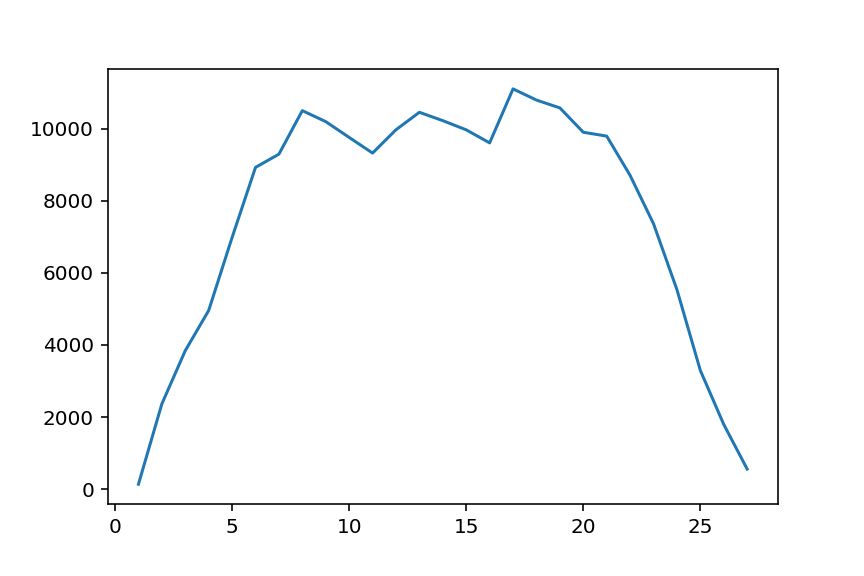

In [7]:
x = np.arange(1,total['NShrink']+1,1)
x1 = np.arange(1,total['NShrink']+2,1)

plt.plot(x1,progress['ERI_vec'])

### 1. Libint Integral Engine, segmented contration

In [8]:
# Construct the name of the output files 
root = '/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/'
system = 'Au'
basis = 'jorgetzpdkh'
integral_engine = 'libint'
contraction_type = 's'
taus = ['1e-8', '1e-6', '1e-4'] 
sigmas = ['1','5e-1','1e-1','5e-2','1e-2','5e-3','1e-3','5e-4','1e-4','5e-5','1e-5']
maxquals = [20000,5000,2000,1500,1250,1000,750,500,250,100,50,20,1]

Au14_Total = {}
Au14_Progress = {}

for tau in taus:
    for sigma in sigmas:
        for maxqual in maxquals:

            fname = root + system
            
            fname += '_%s_%s%s' % (basis,integral_engine,contraction_type)

            fname += '_t%s_s%s_m%d' % (tau,sigma,maxqual)

            fname += '.out'
            
            #print(fname)

            Au14_Progress[(tau,sigma,maxqual)], Au14_Total[(tau,sigma,maxqual)] = parseOutput(fname)

#### 1.1 We first look at the cumulative data

#### 1.1.1 Effect on T1ERI

<IPython.core.display.Javascript object>


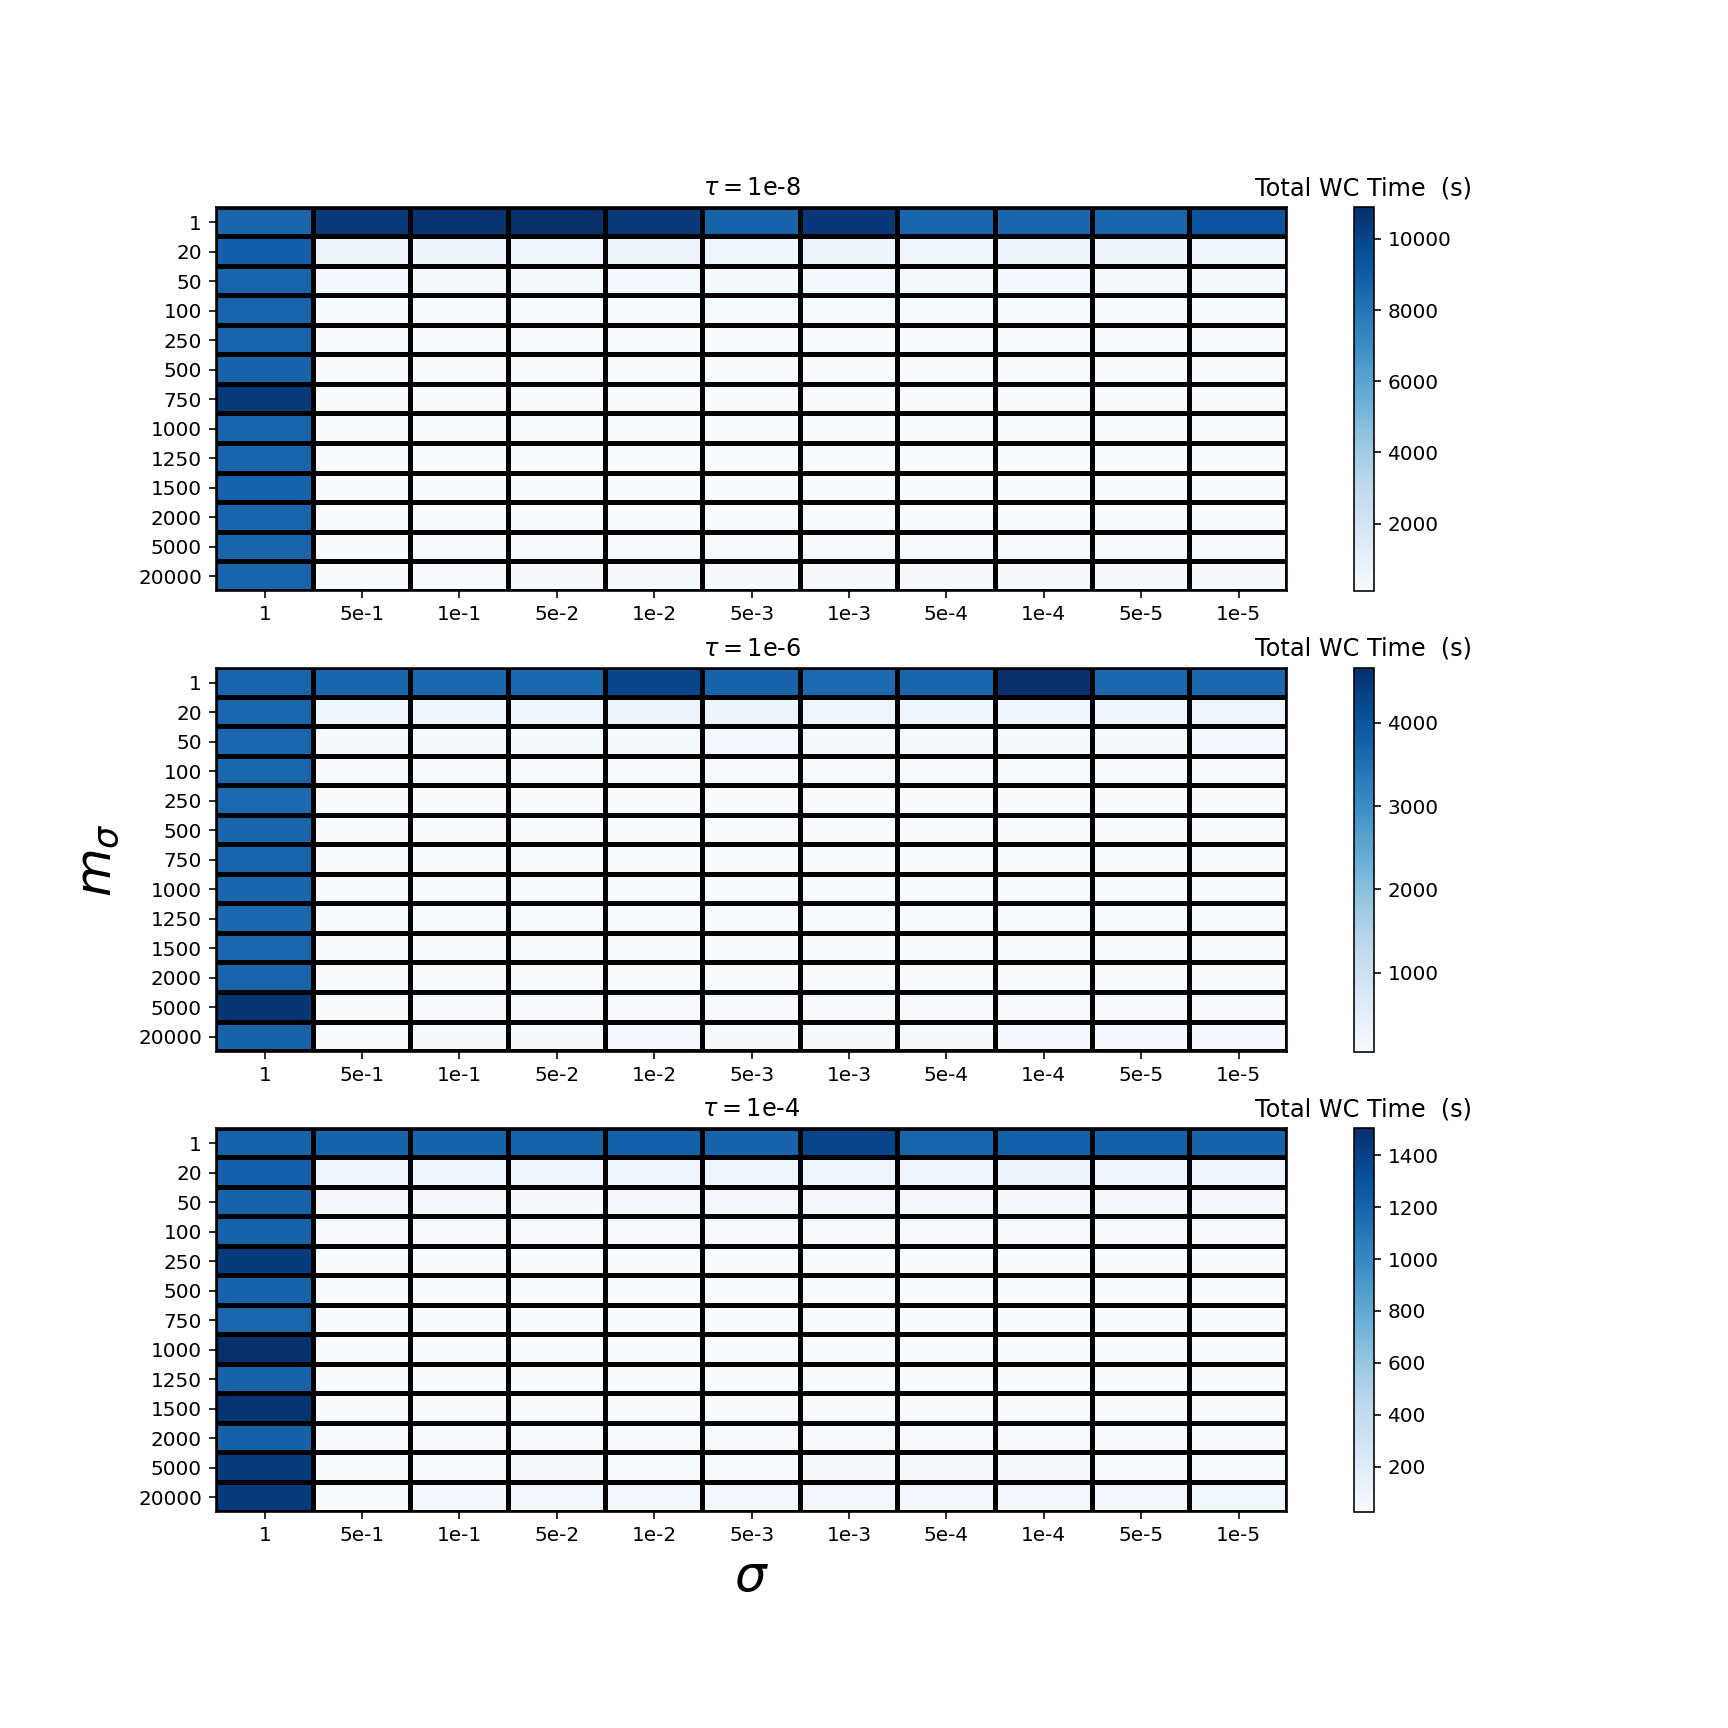

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [9]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('Blues')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['T1'])
            #print('add data for ' + 'tau=' + tau + ' sig=' + sigma + 'msig=' + maxqual )
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest',edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total WC Time  (s)')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)


#### 1.1.2 Effect on ERI Count

<IPython.core.display.Javascript object>


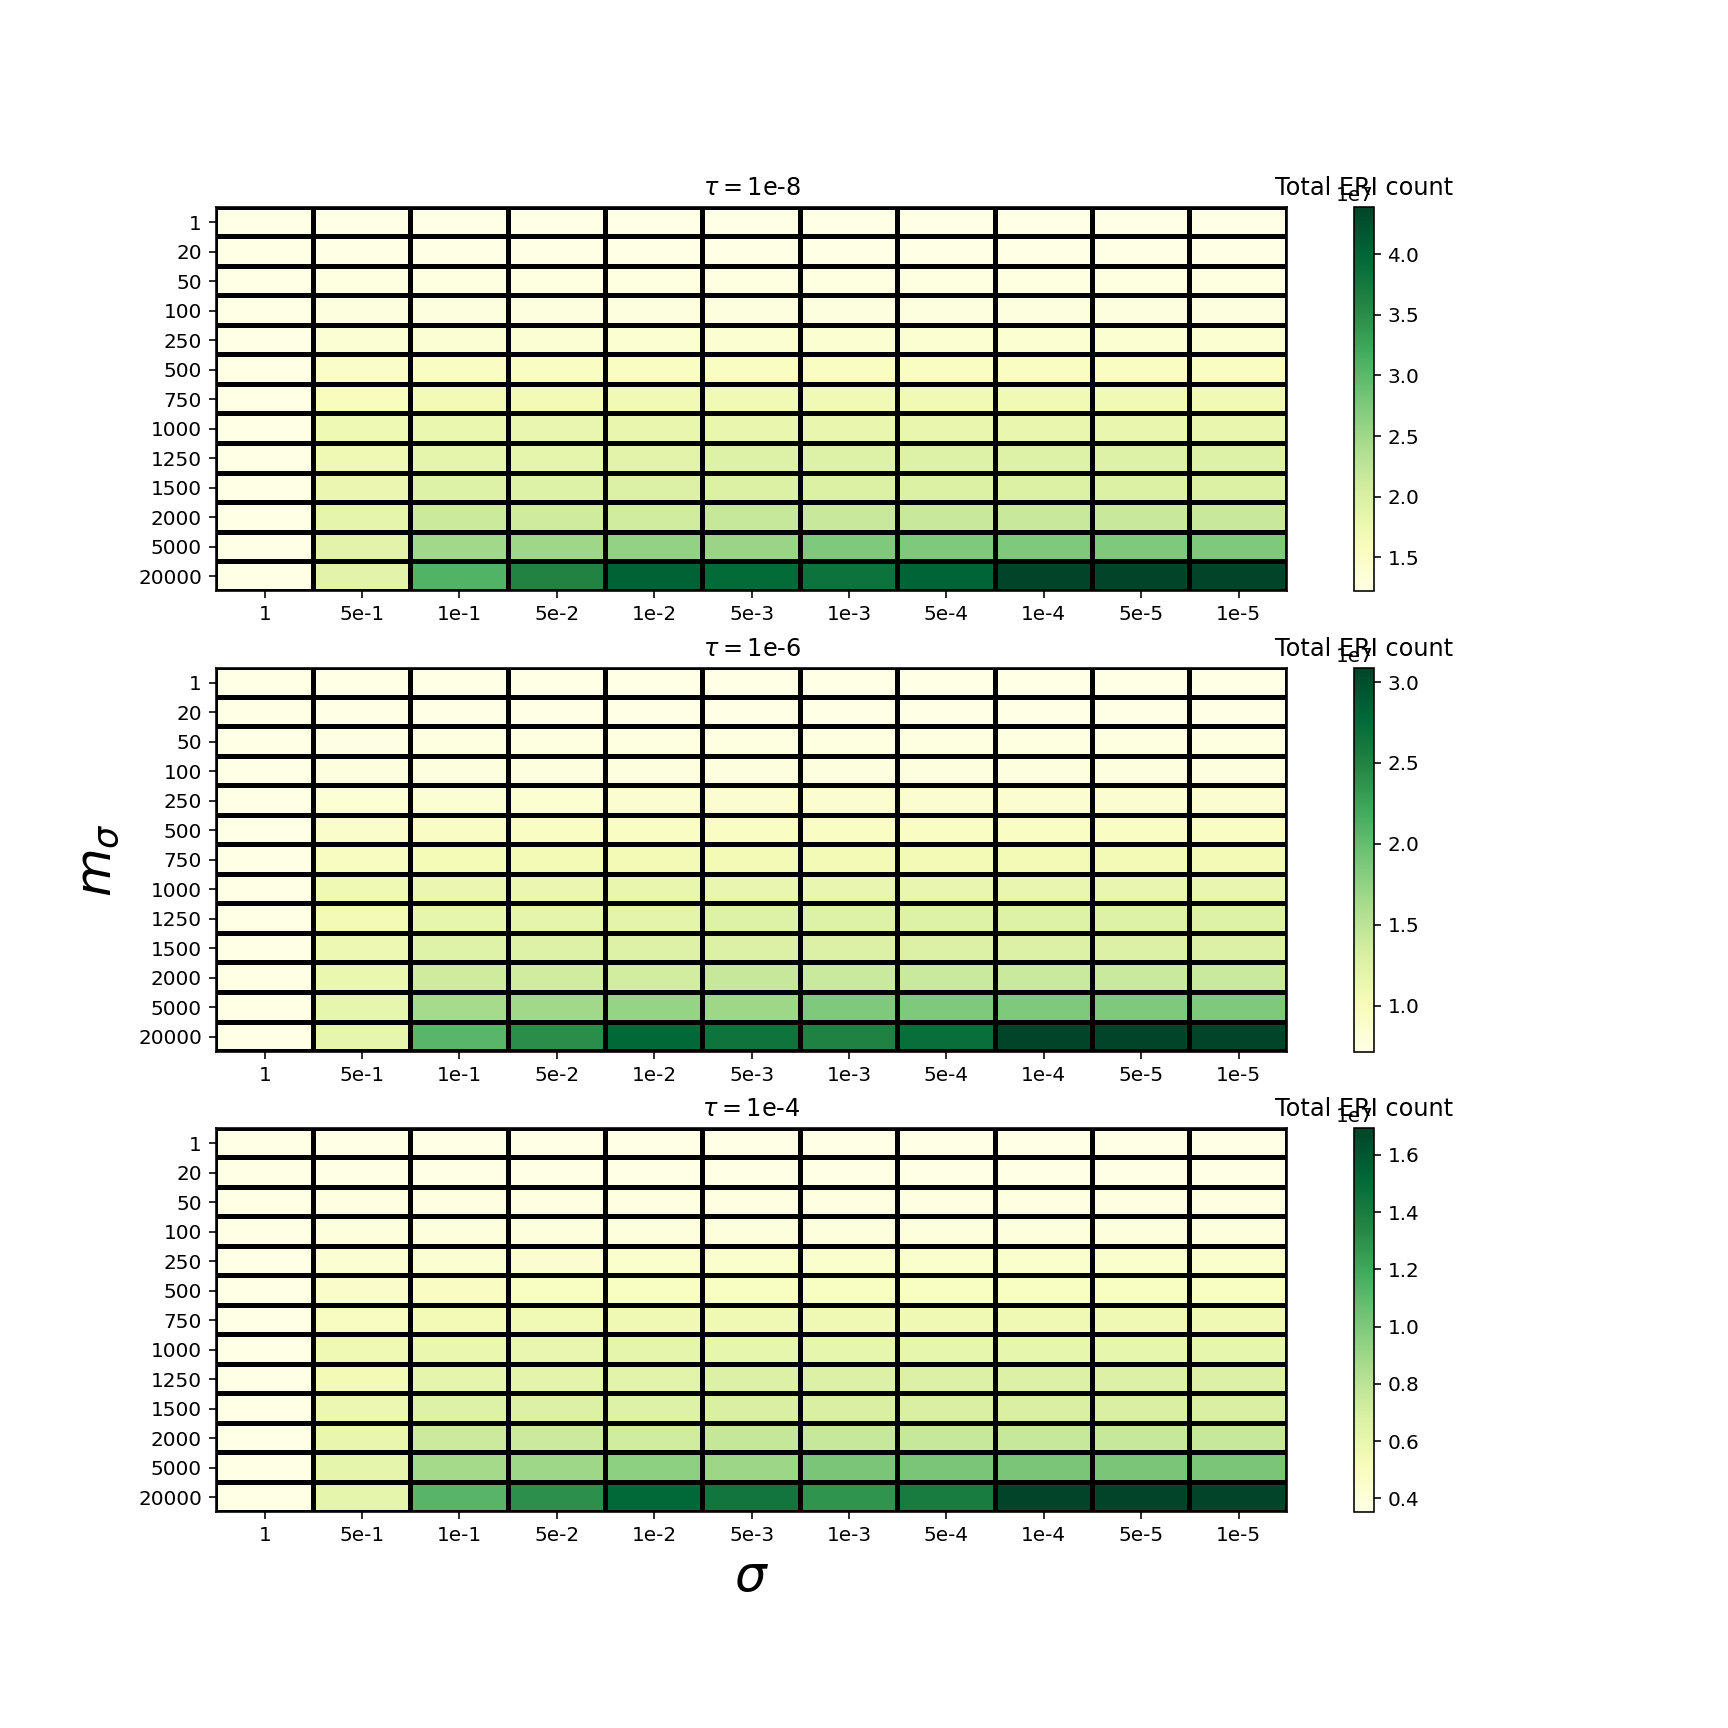

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [10]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('YlGn')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['N1ERI'])
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest', vmin=Z.min(), vmax=Z.max(),edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total ERI count')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)

#### 1.1.3 Effect on ERI Time

<IPython.core.display.Javascript object>


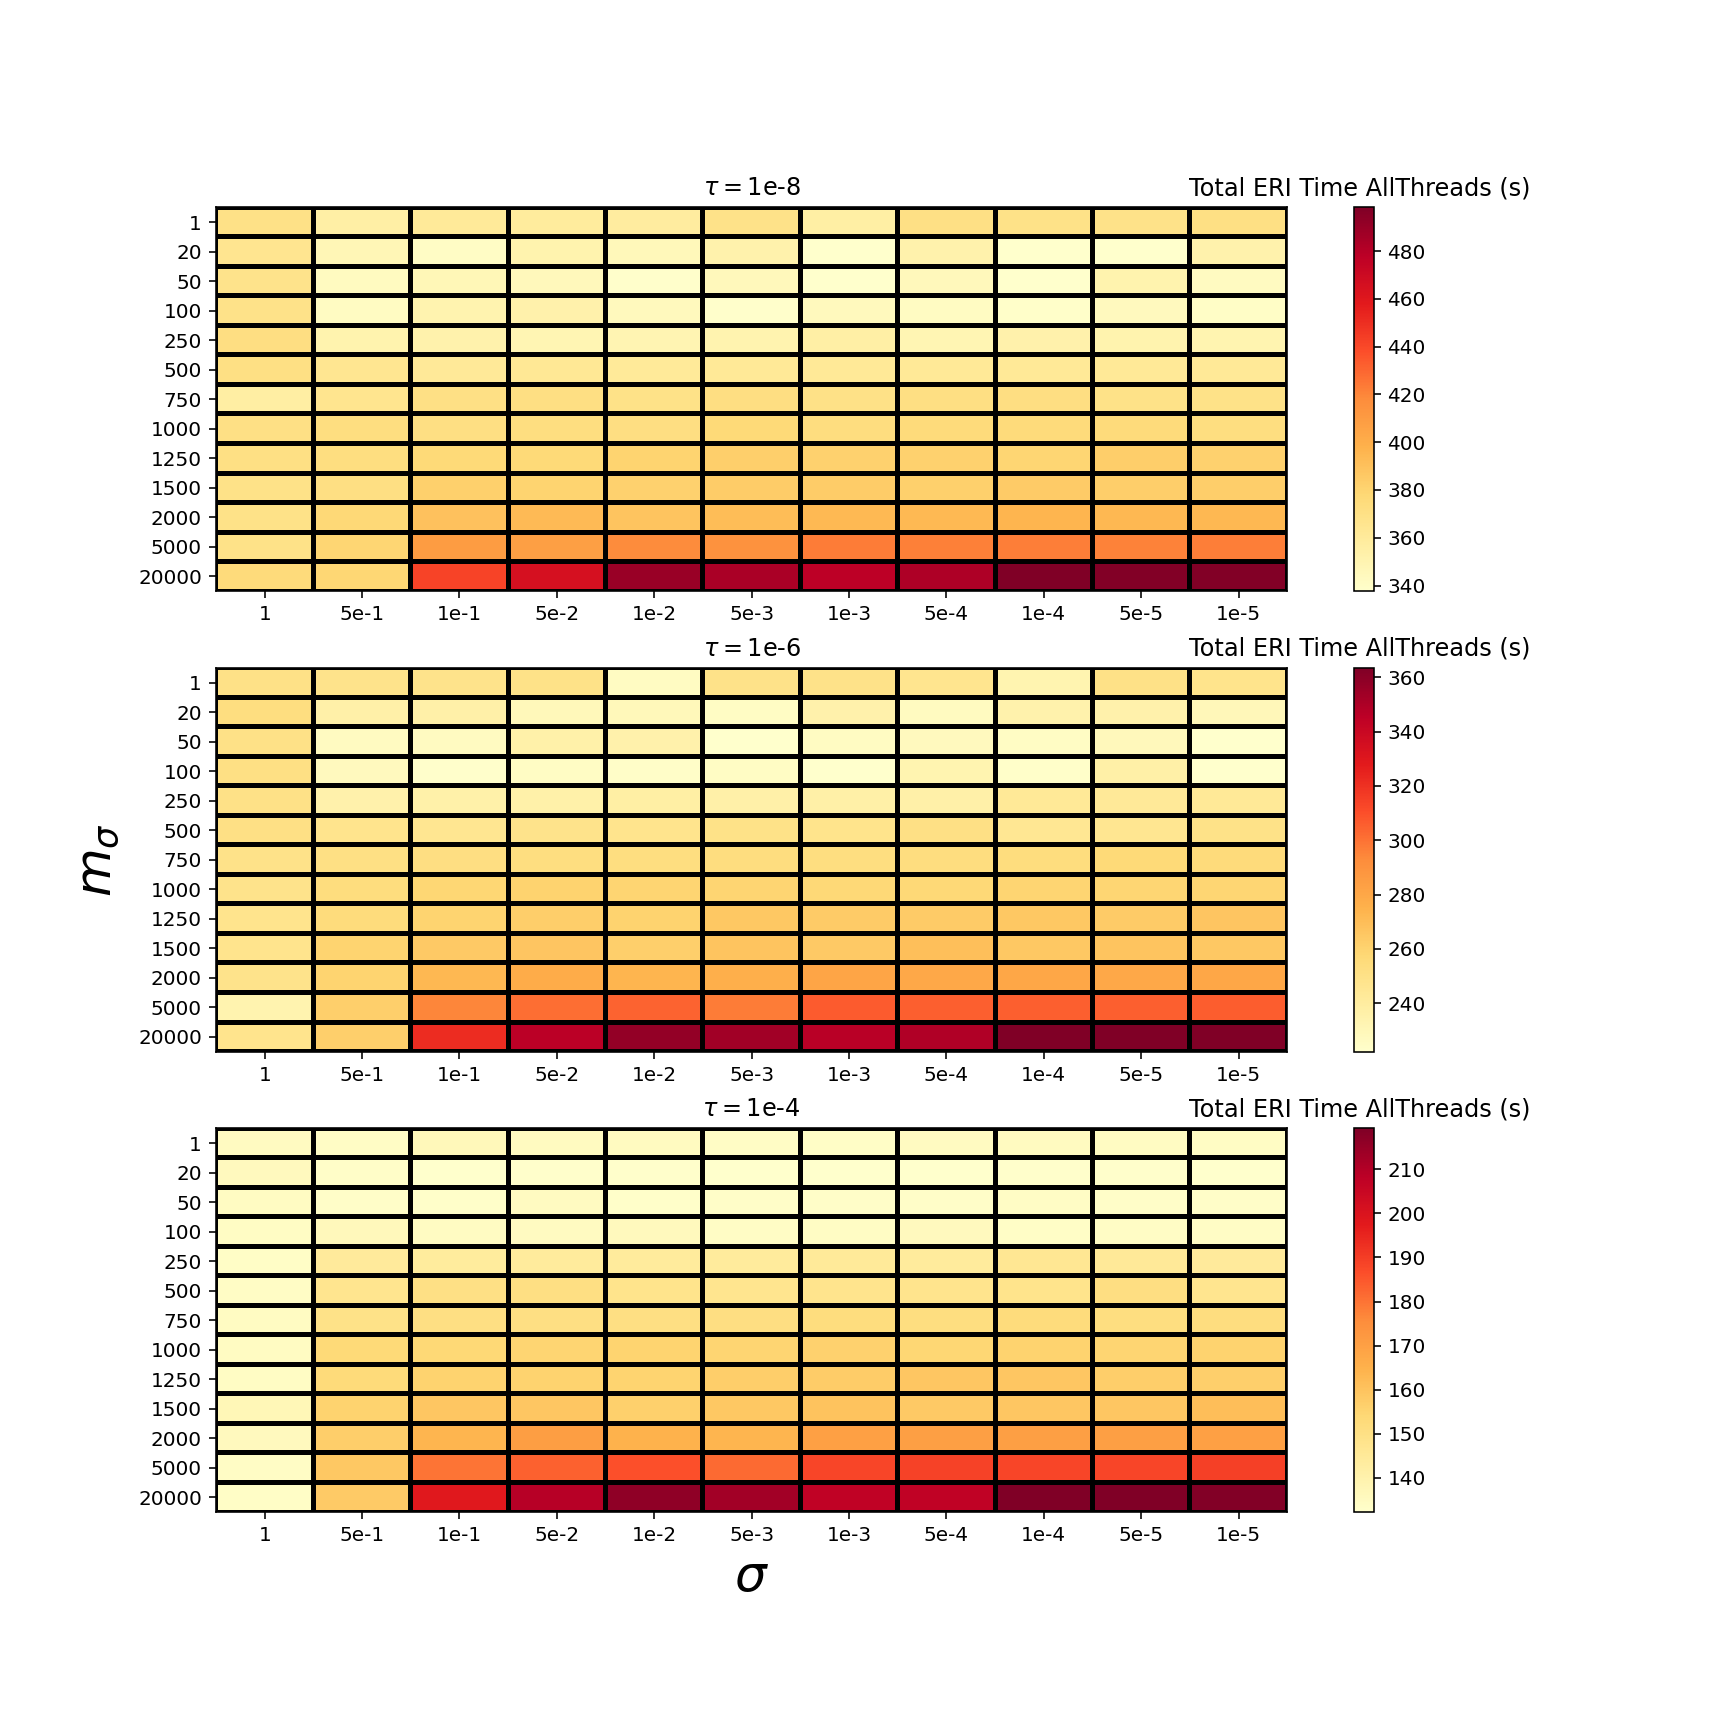

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [11]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('YlOrRd')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['T1ERI_AllThreads'])
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest', vmin=Z.min(), vmax=Z.max(),edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total ERI Time AllThreads (s) ')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)

<IPython.core.display.Javascript object>


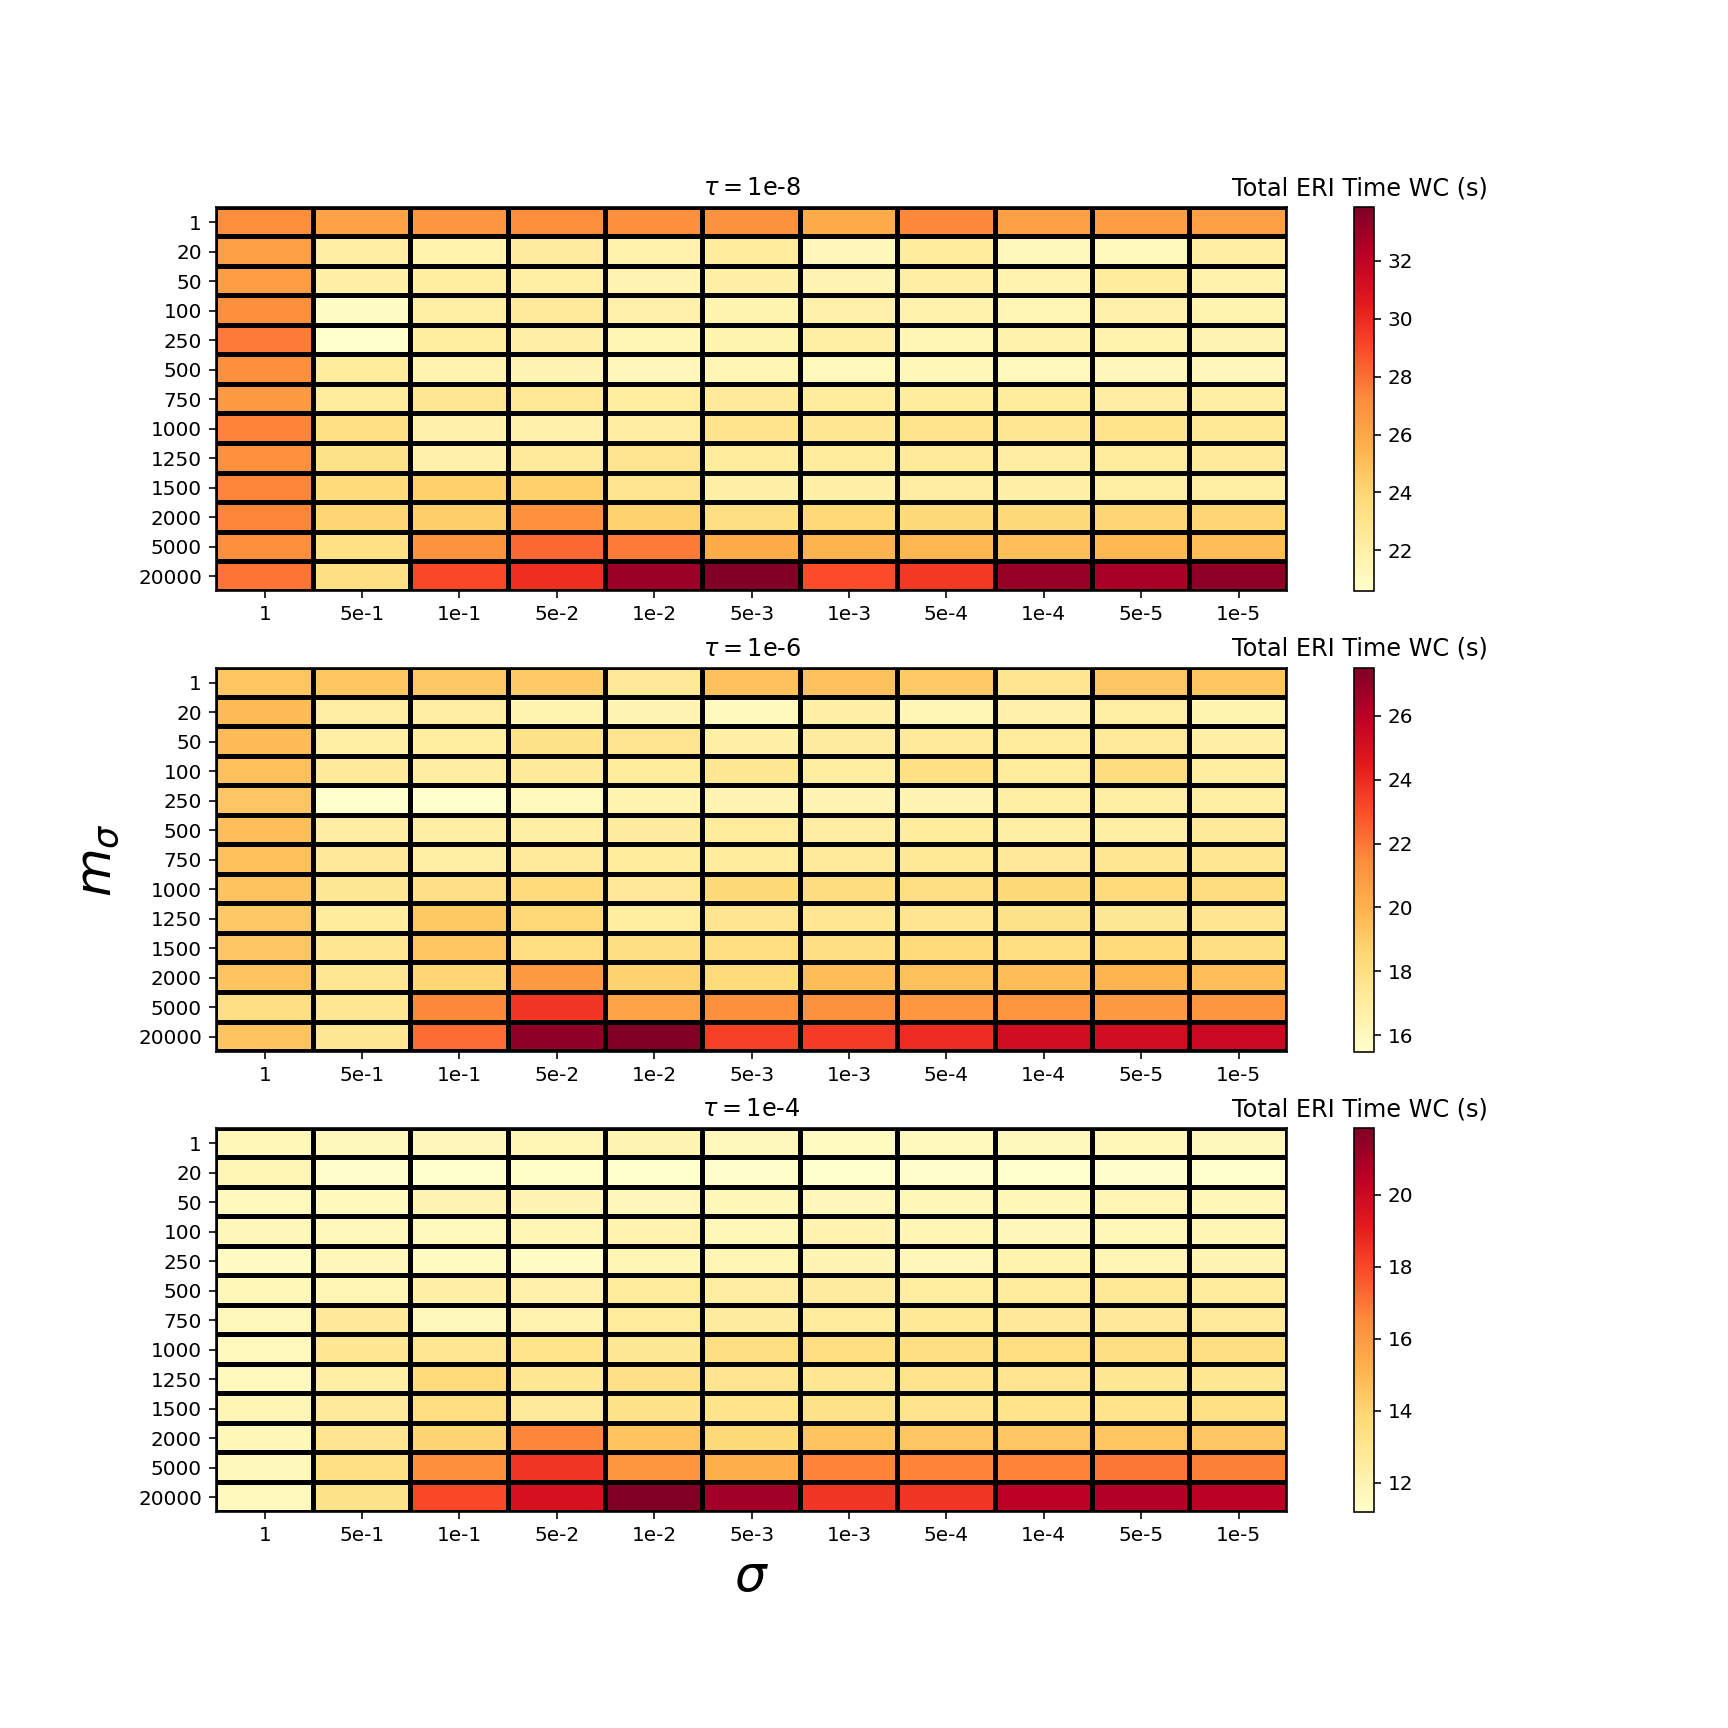

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [12]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('YlOrRd')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['T1ERI_WC'])
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest', vmin=Z.min(), vmax=Z.max(),edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total ERI Time WC (s) ')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)

#### 1.1.4 Effect on Shrinking

<IPython.core.display.Javascript object>


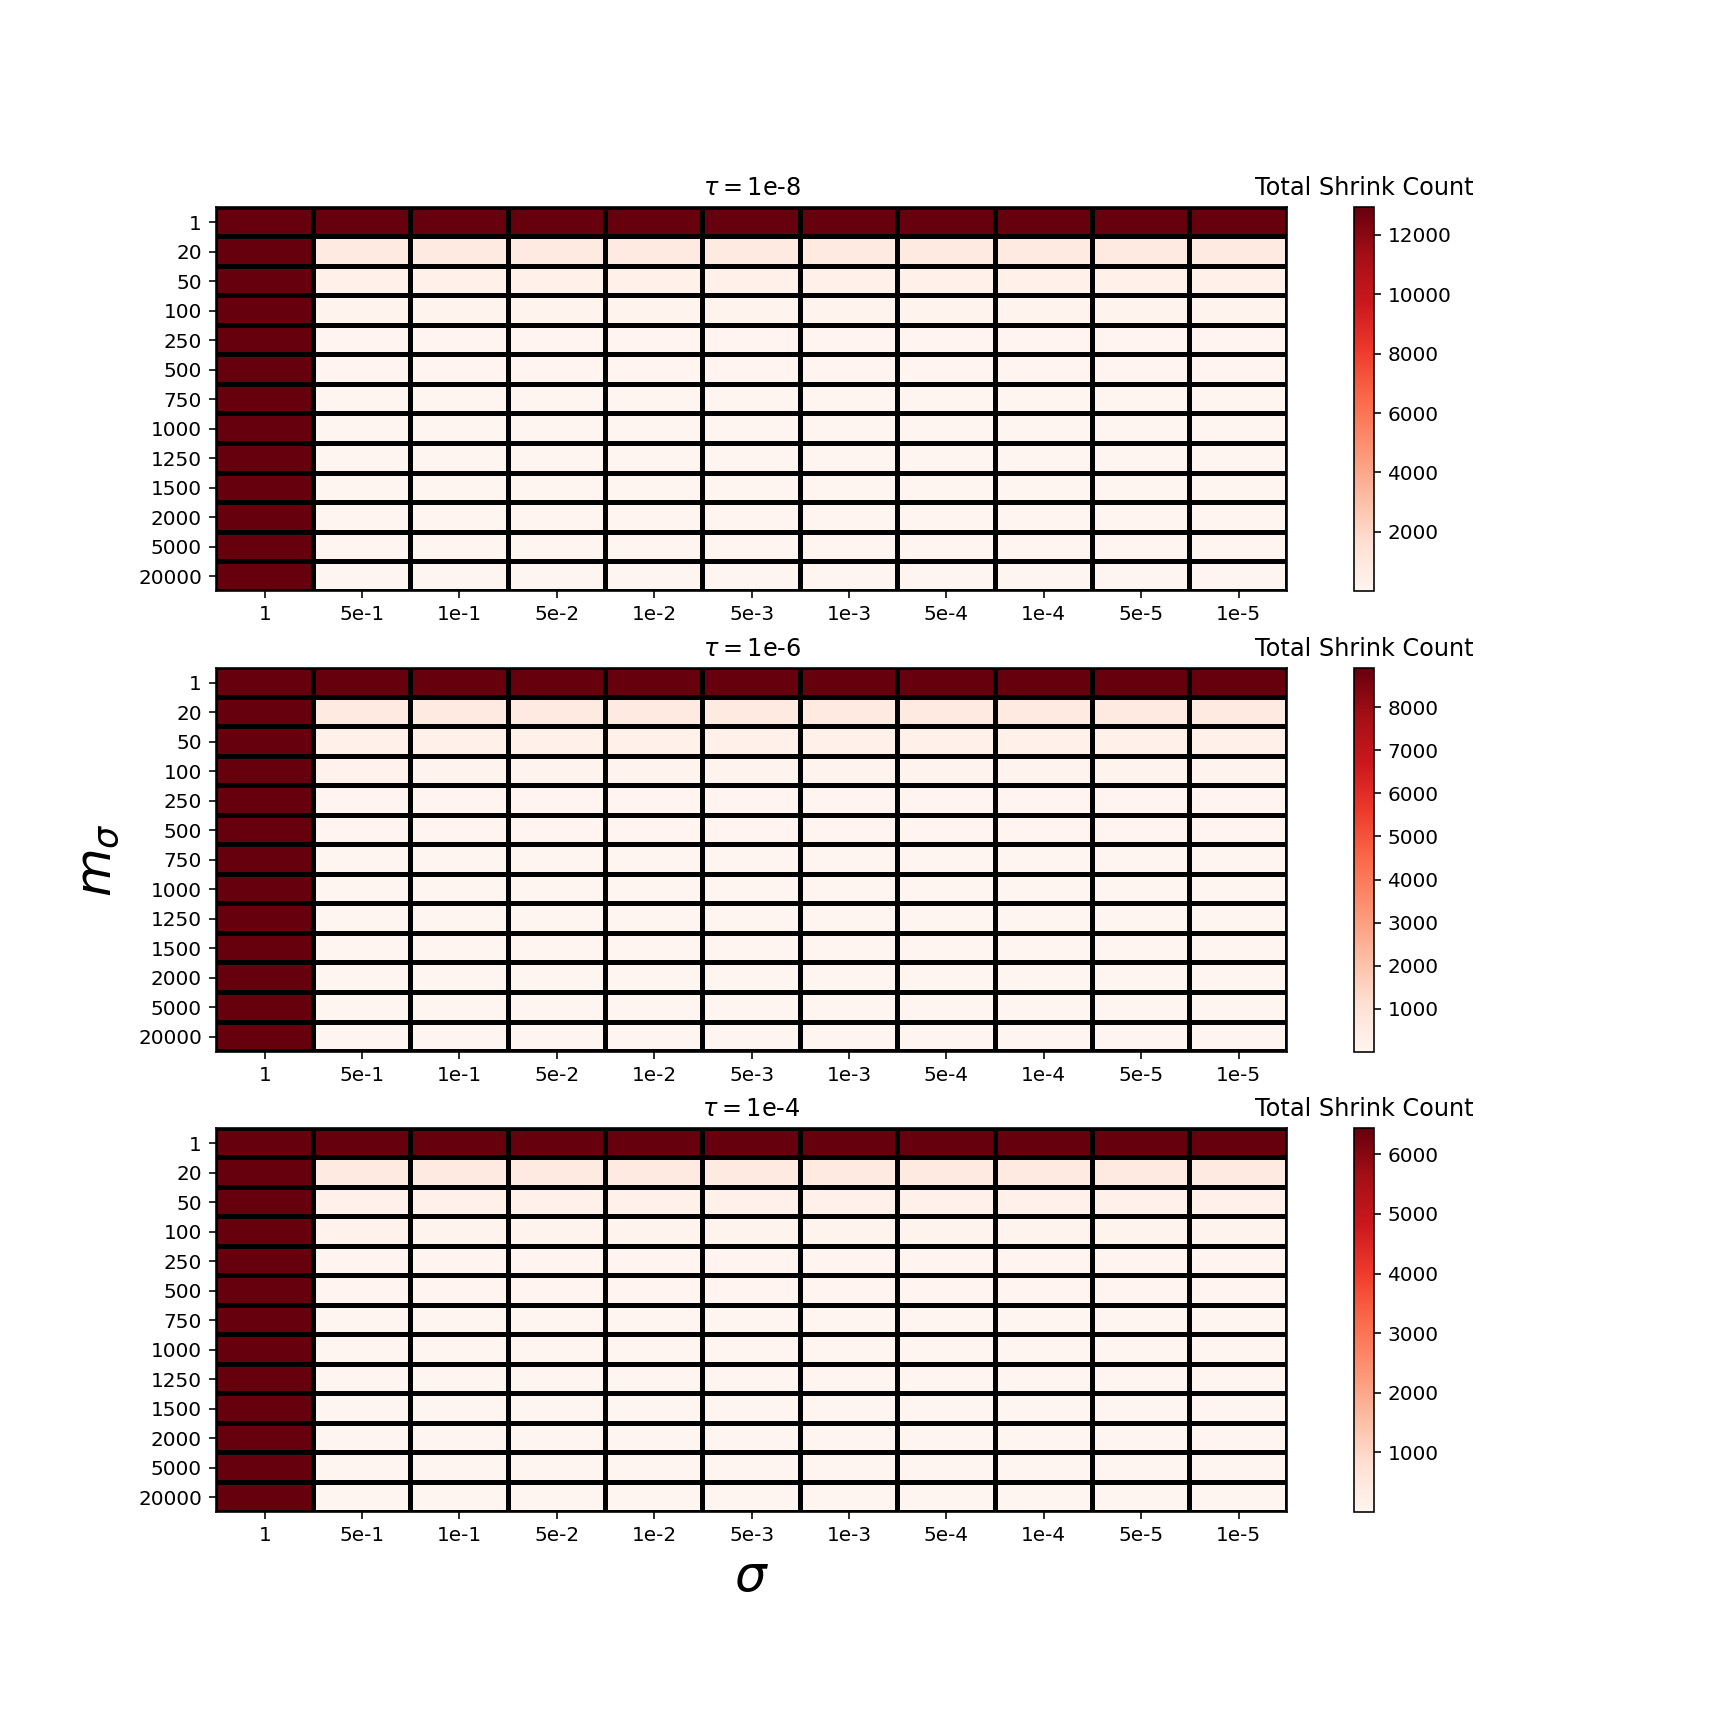

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [13]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('Reds')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['NShrink'])
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest', vmin=Z.min(), vmax=Z.max(),edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total Shrink Count')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)

<IPython.core.display.Javascript object>


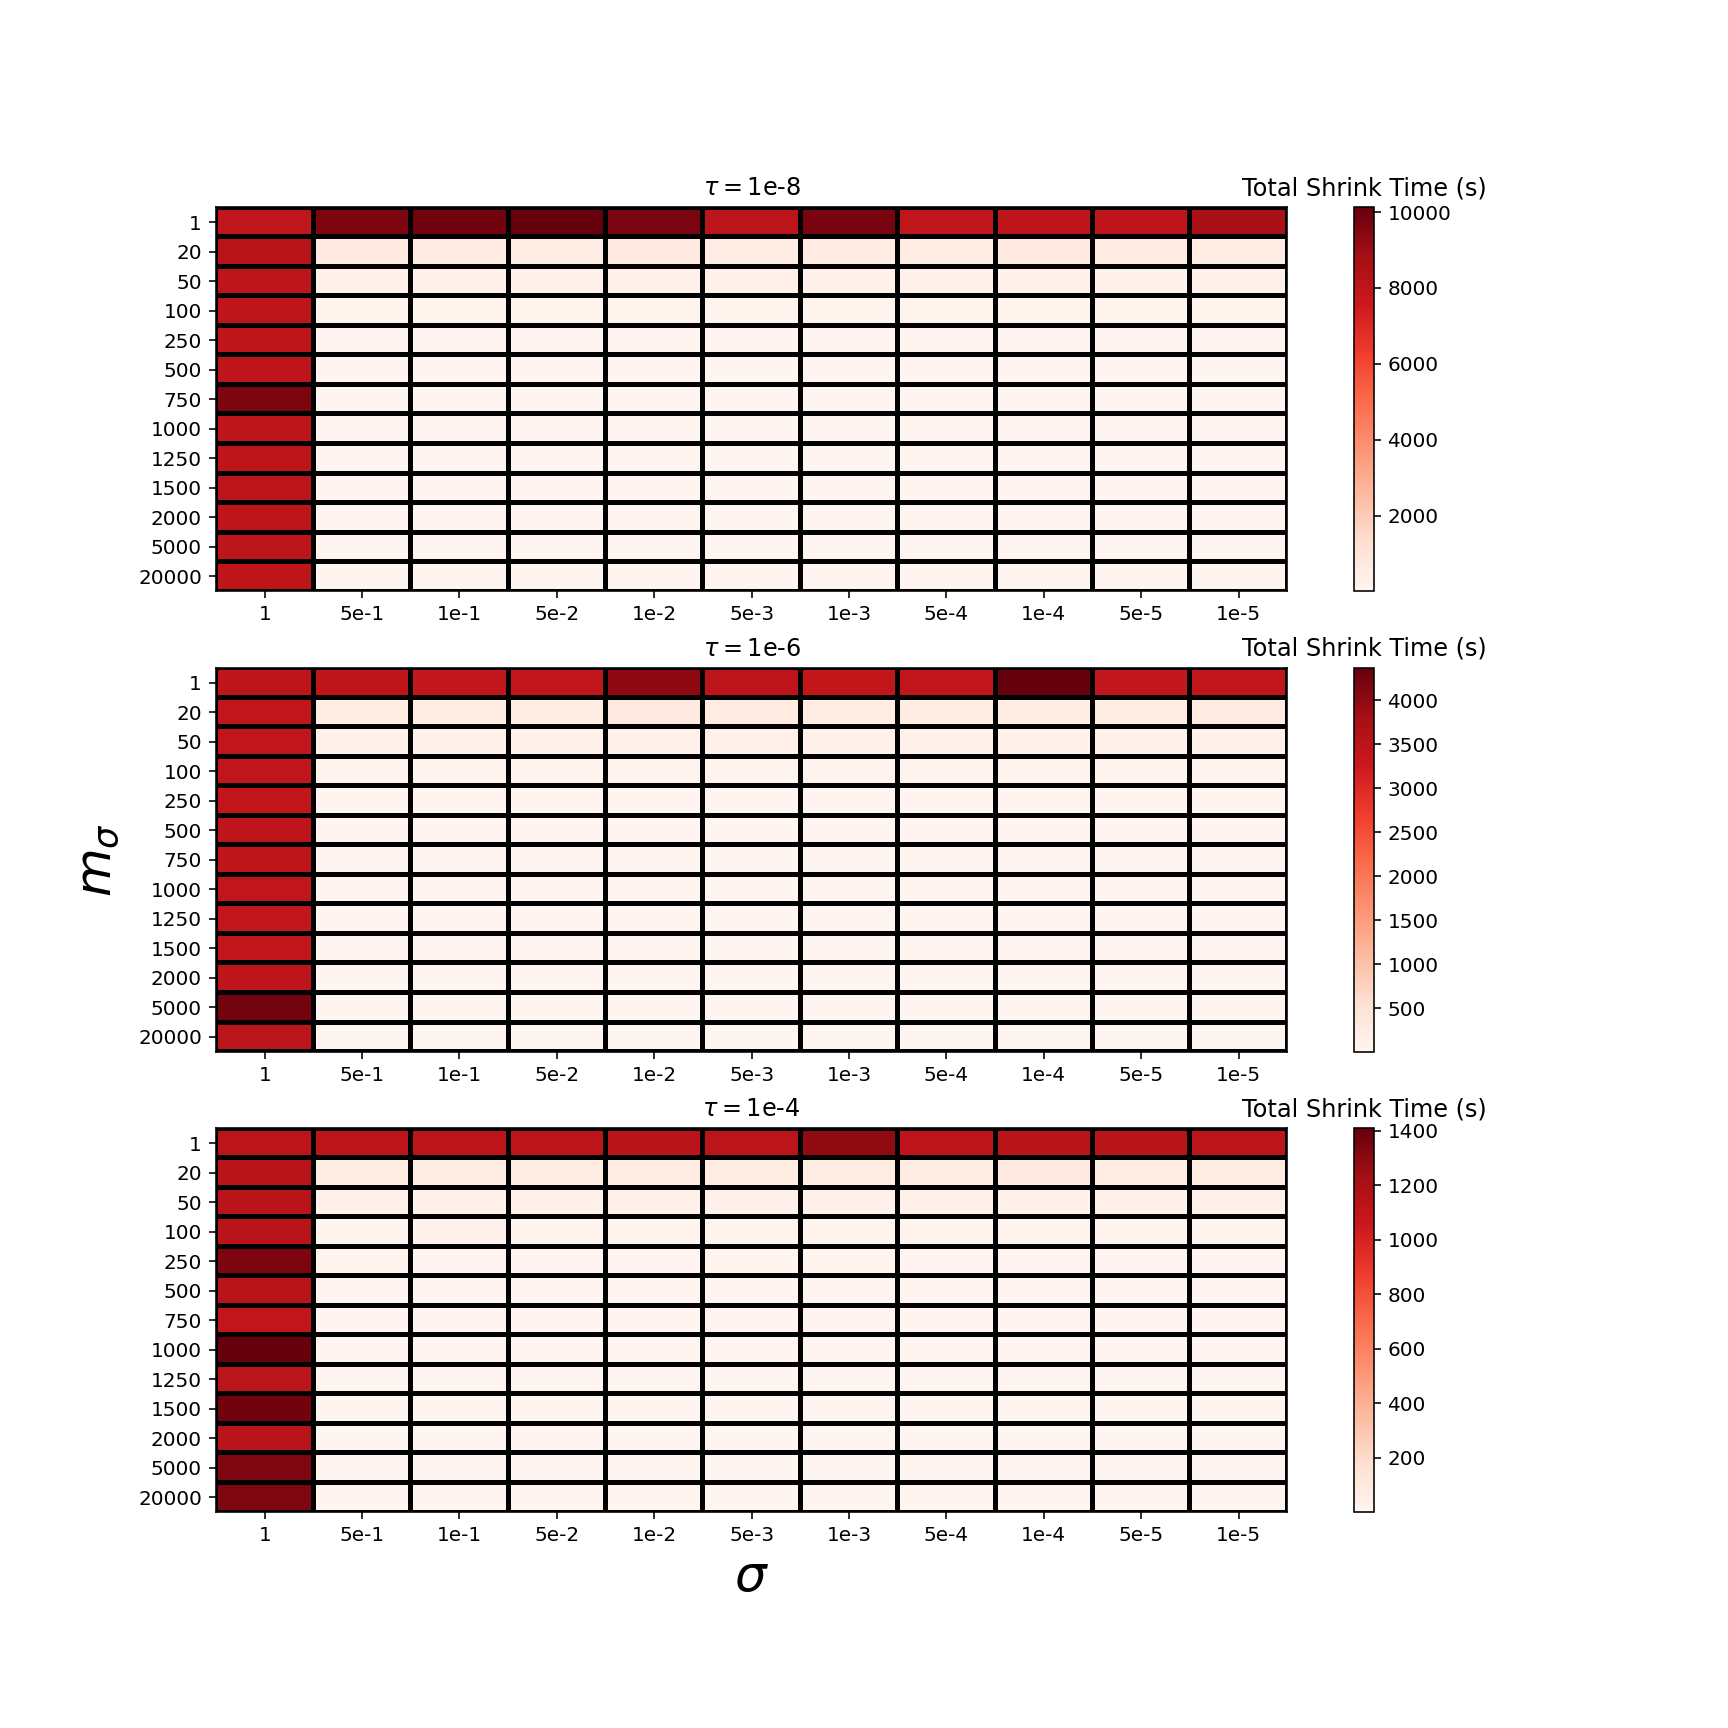

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [14]:
fig, ax = plt.subplots(3,1,figsize=(12,12))

cm = plt.cm.get_cmap('Reds')

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        for sigma in sigmas:
            T1ERI_list.append(Au14_Total[(tau,sigma,maxqual)]['TShrink'])
    x = np.array(sigmas)
    y = np.array(maxquals)
    z = np.array(T1ERI_list)
    X, Y = np.meshgrid(x,y)
    Z = z.reshape(len(maxquals),len(sigmas))
    
    # Generate 2D plot. All ticks are evenly spaced (despite their numerical values) since I'm plotting strings
    im = ax[i].pcolormesh(x, y.astype('str'), Z, cmap=cm, shading='nearest', vmin=Z.min(), vmax=Z.max(),edgecolors='k', linewidths=2)
    # Display the colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_title('Total Shrink Time (s)')
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$\sigma$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "$m_{\sigma}$",25)

#### Now set $\sigma$ to 0 and investigate the effect of $m_{\sigma}$

In [15]:
# Construct the name of the output files 
root = '/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/'
system = 'Au'
basis = 'jorgetzpdkh'
integral_engine = 'libint'
contraction_type = 's'
taus = ['1e-8', '1e-6', '1e-4'] 
sigma = 0
maxquals = np.arange(20,2020,20)

Au14_S0_Total = {}
Au14_S0_Progress = {}

for tau in taus:
    for maxqual in maxquals:

        fname = root + system

        fname += '_%s_%s%s' % (basis,integral_engine,contraction_type)

        fname += '_t%s_s%s_m%d' % (tau,sigma,maxqual)

        fname += '.out'

        print(fname)

        Au14_S0_Progress[(tau,sigma,maxqual)], Au14_S0_Total[(tau,sigma,maxqual)] = parseOutput(fname)


/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m20.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m40.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m60.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m80.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m100.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m120.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m140.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m160.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_se

/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1660.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1680.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1700.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1720.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1740.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1760.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1780.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-8_s0_m1800.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au

/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1180.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1200.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1220.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1240.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1260.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1280.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1300.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-6_s0_m1320.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au

/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m580.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m600.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m620.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m640.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m660.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m680.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m700.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/Au_jorgetzpdkh_libints_t1e-4_s0_m720.out
/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libin

<IPython.core.display.Javascript object>


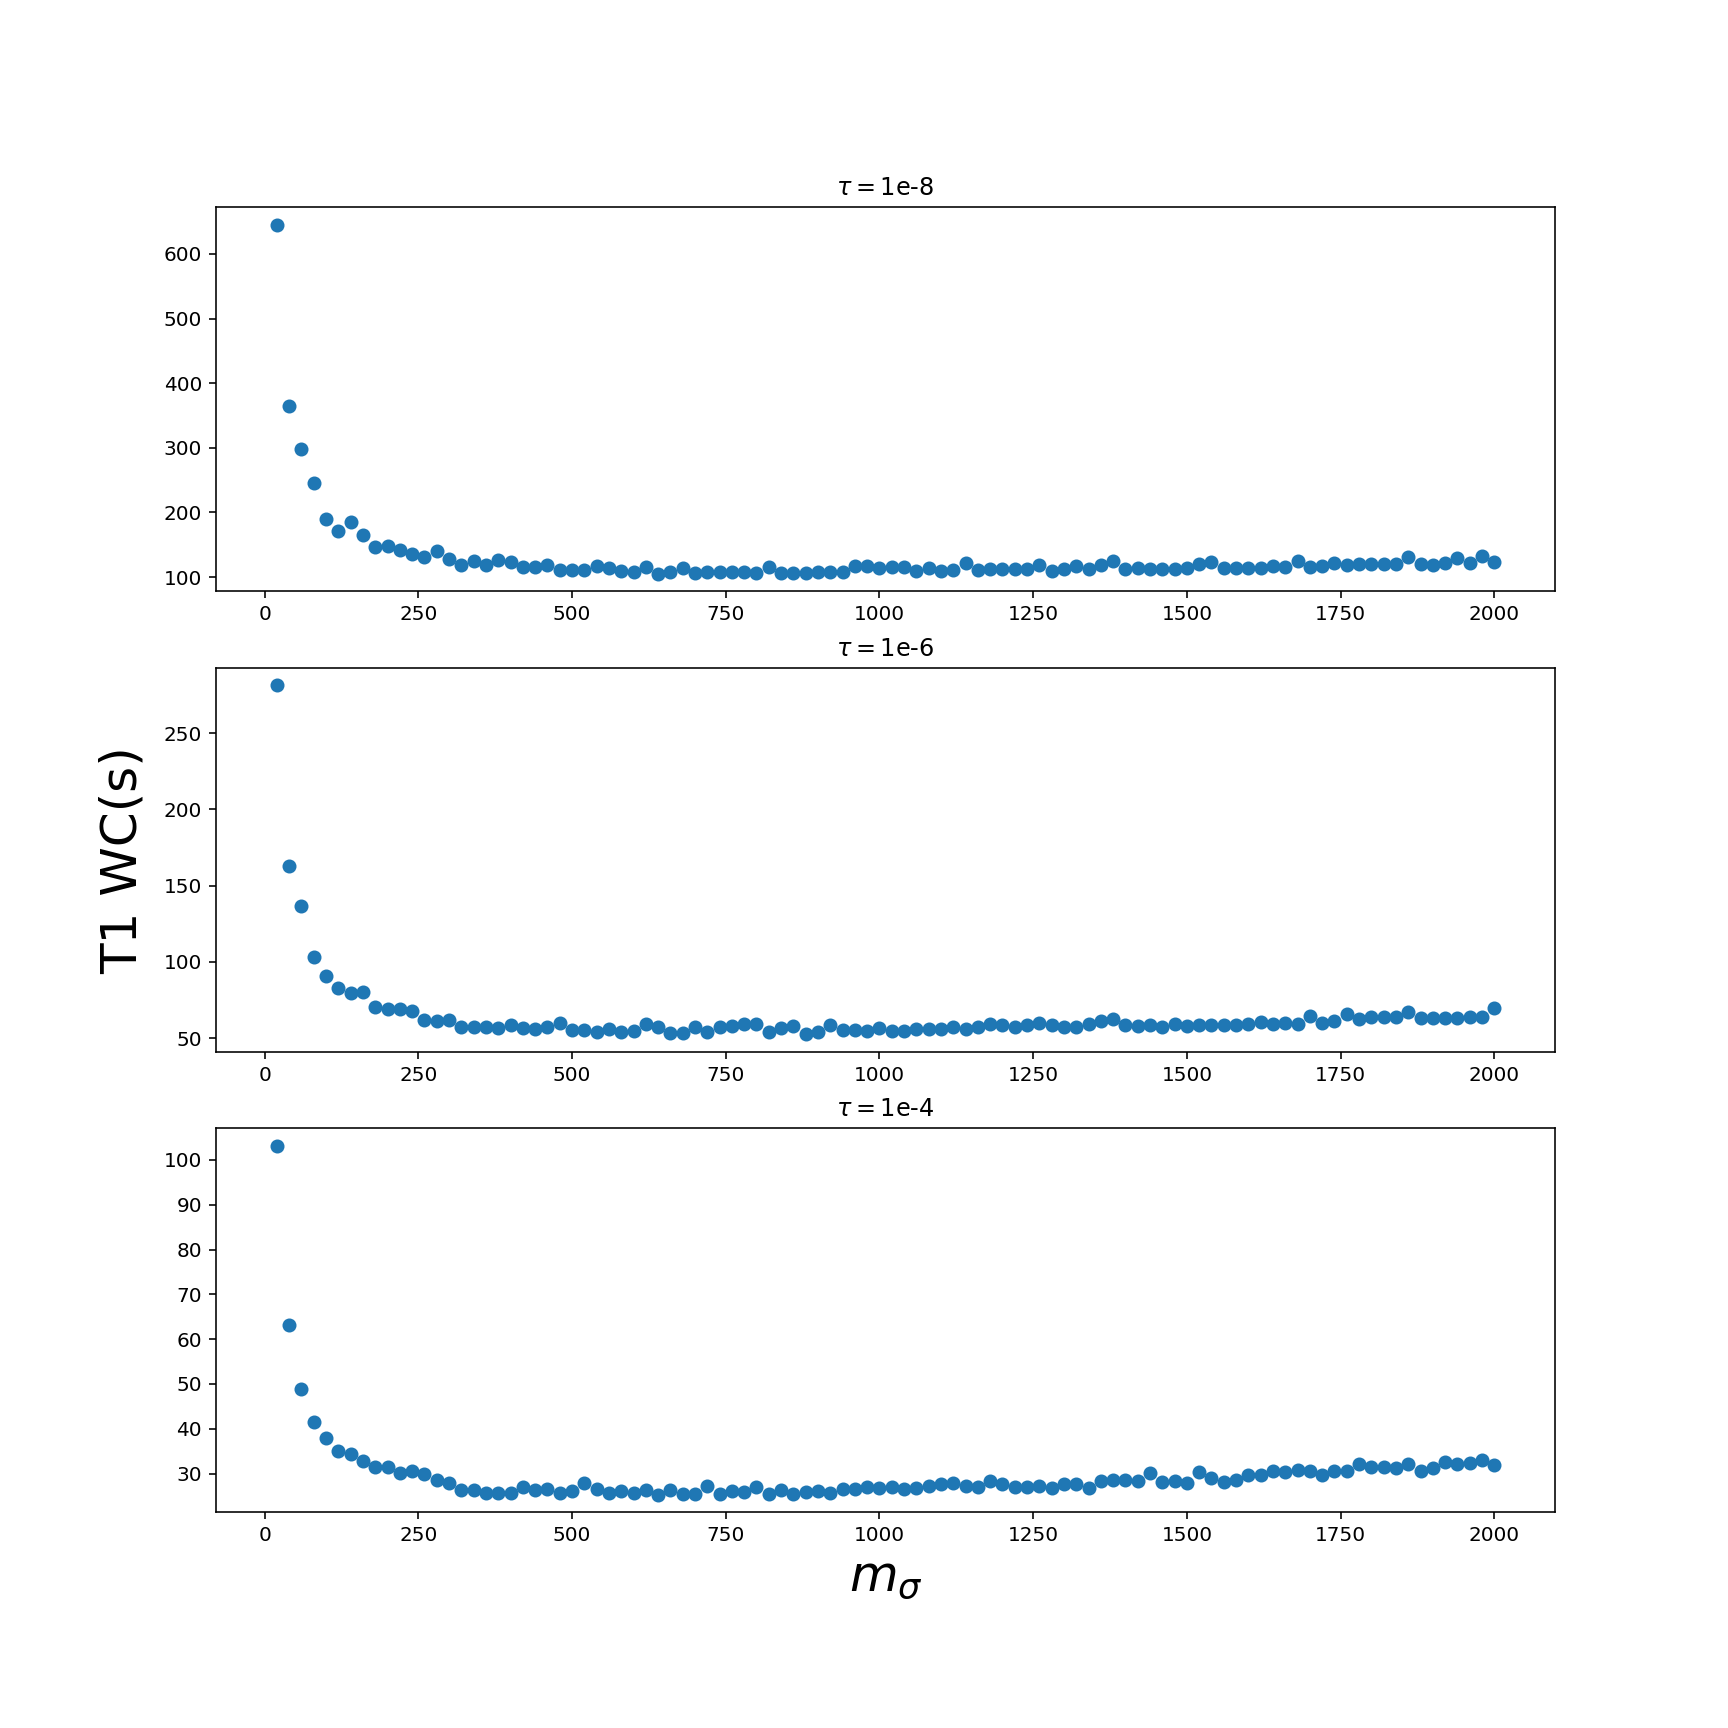

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [16]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "T1 WC(s)",25)
plt.show()


<IPython.core.display.Javascript object>


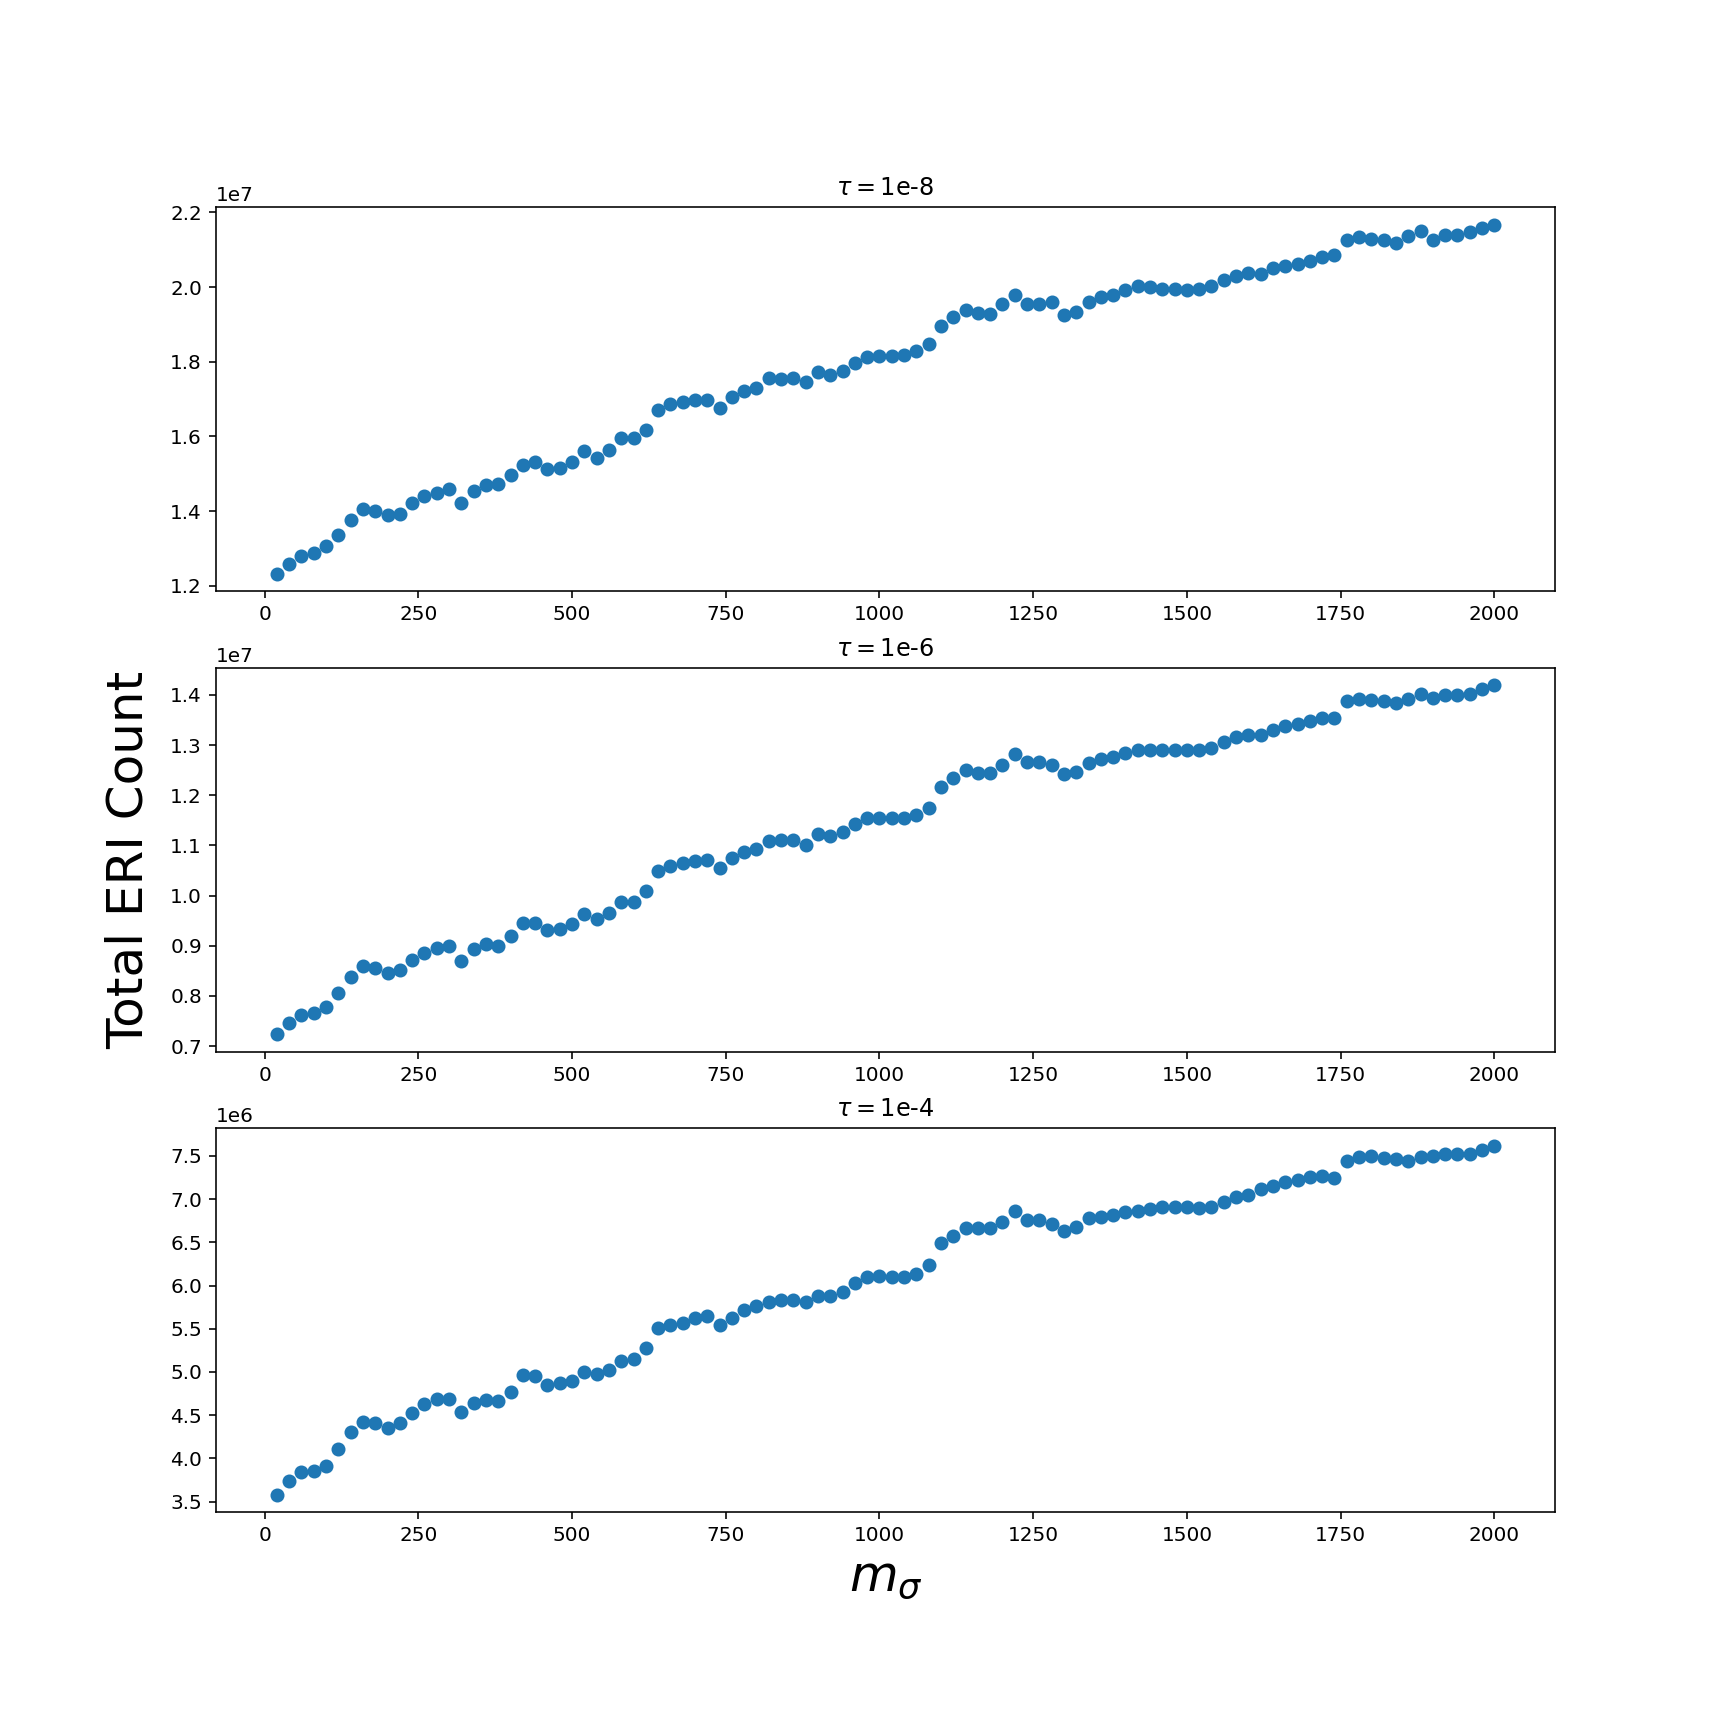

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [18]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['N1ERI'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Count",25)
plt.show()

<IPython.core.display.Javascript object>


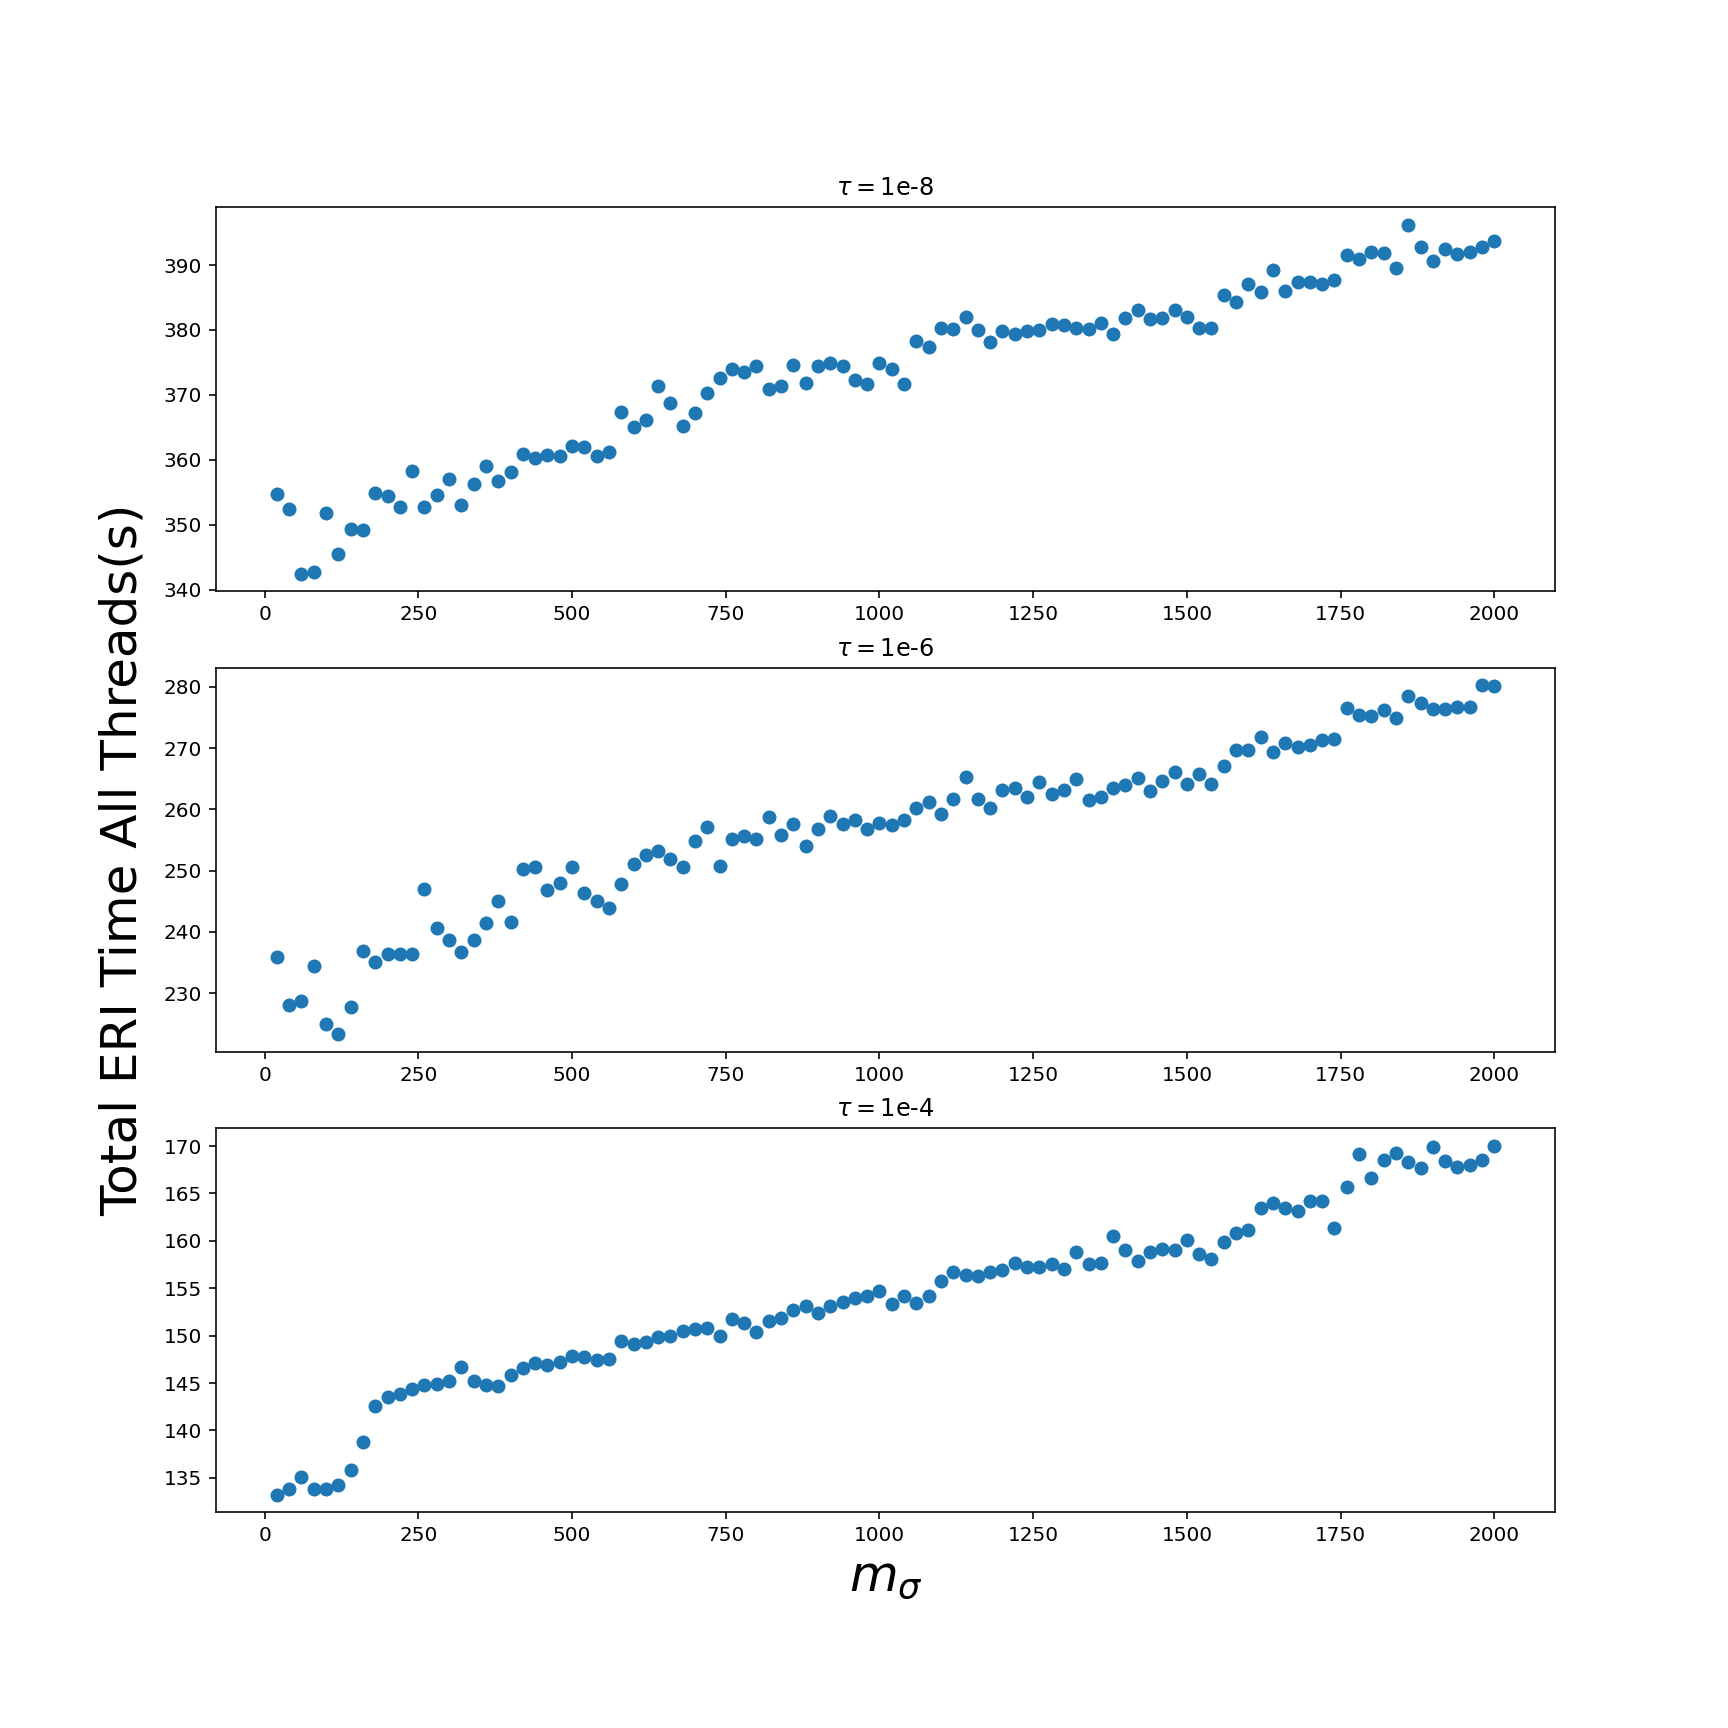

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [19]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1ERI_AllThreads'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Time All Threads(s)",25)
plt.show()

<IPython.core.display.Javascript object>


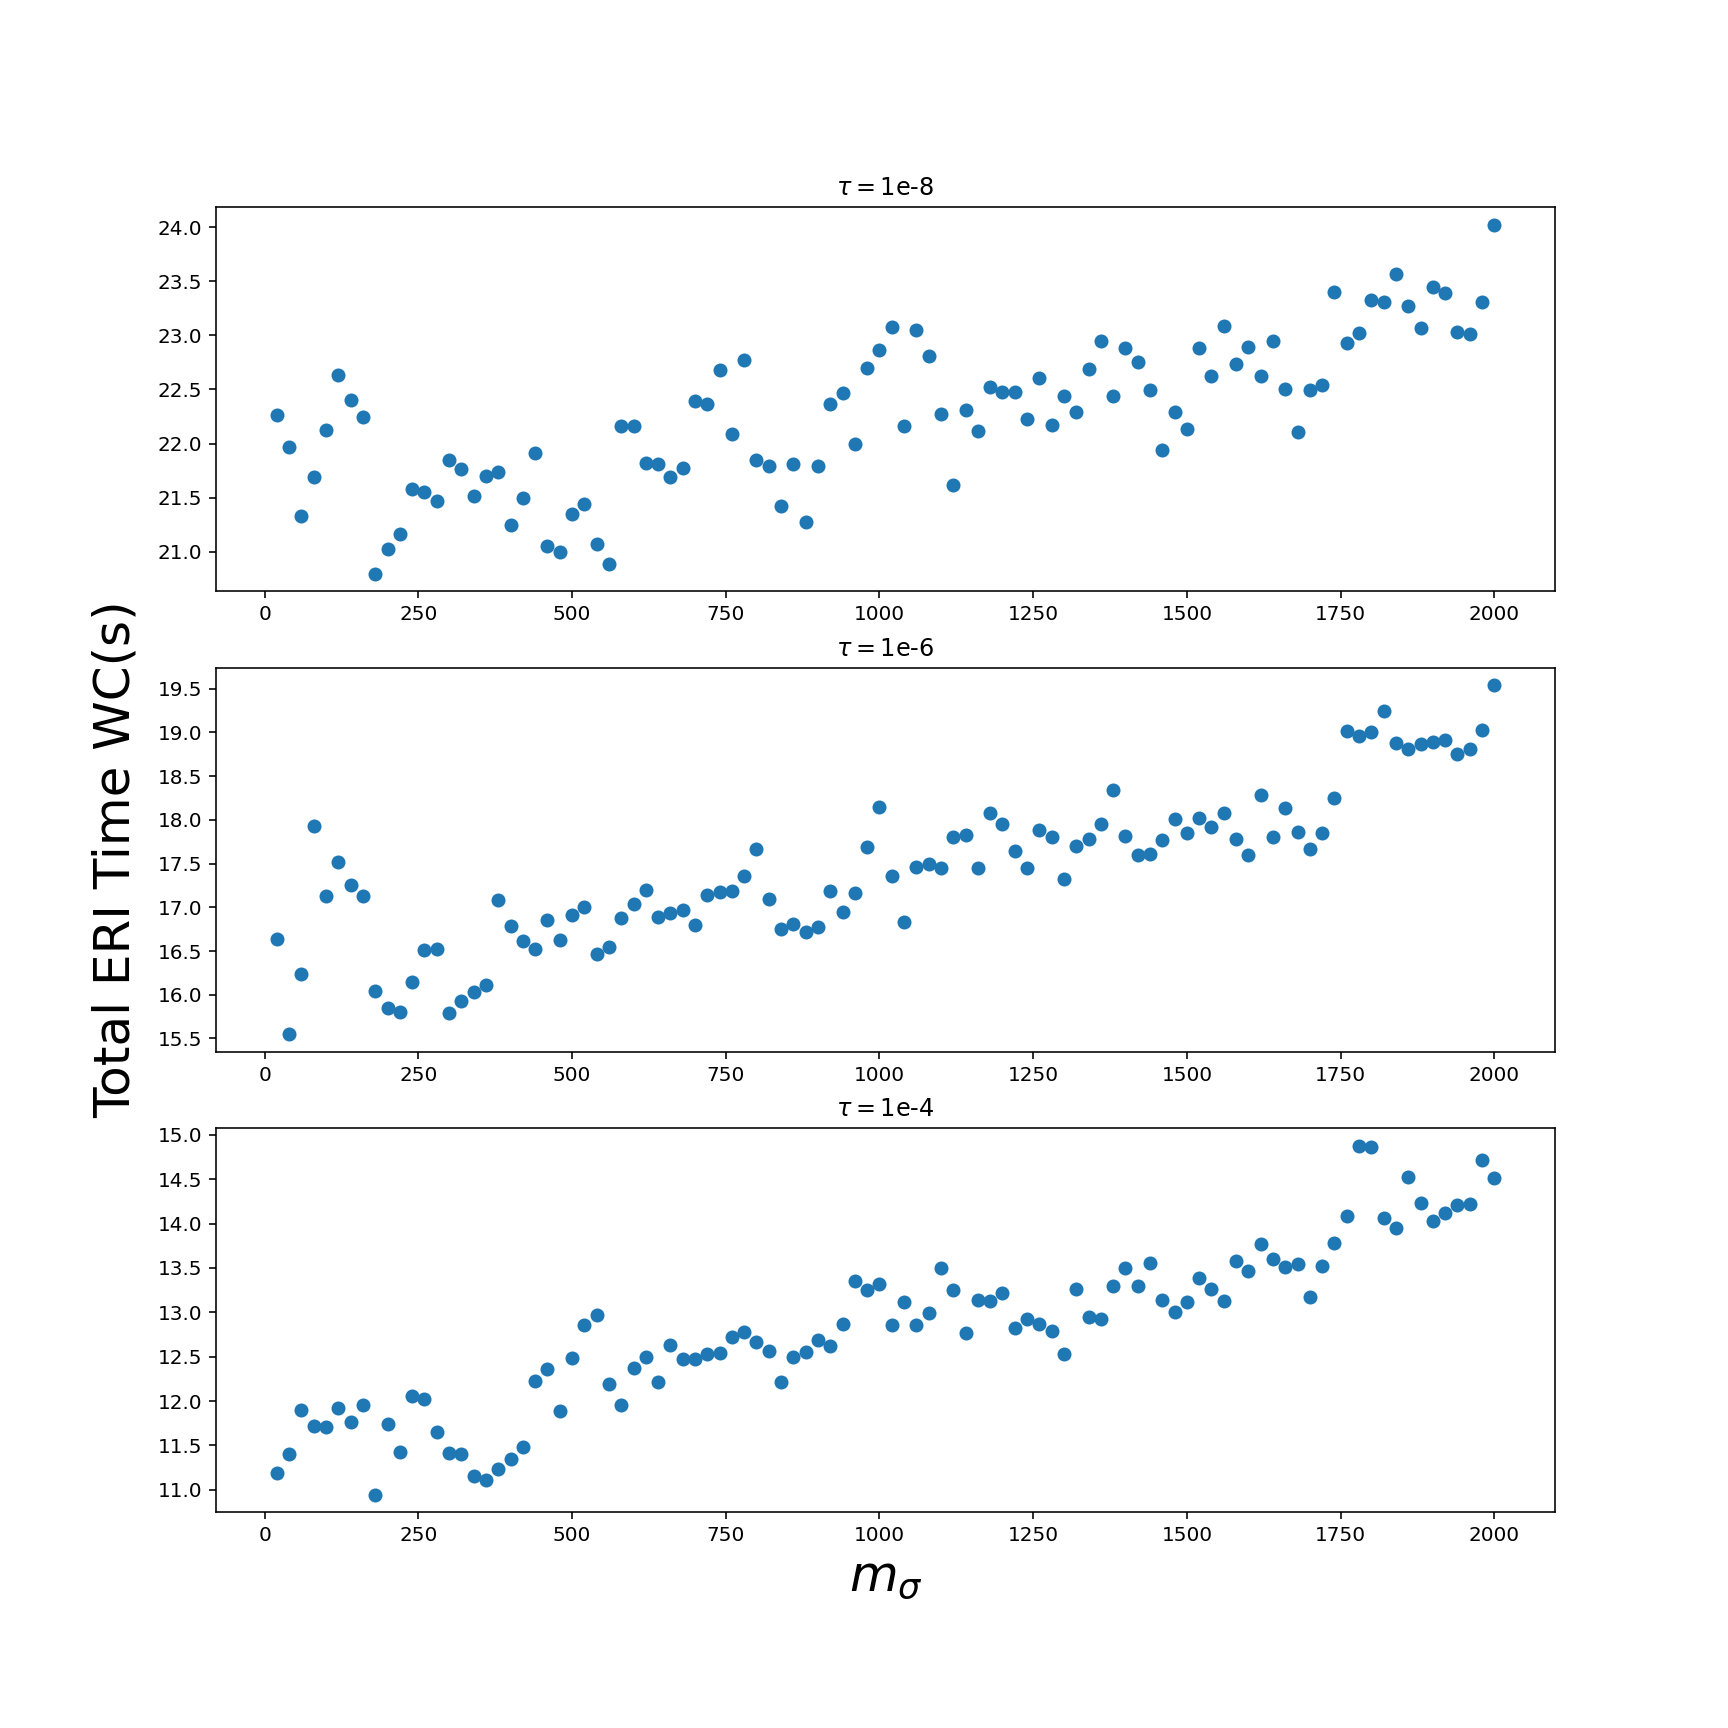

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [20]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1ERI_WC'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Time WC(s)",25)
plt.show()

<IPython.core.display.Javascript object>


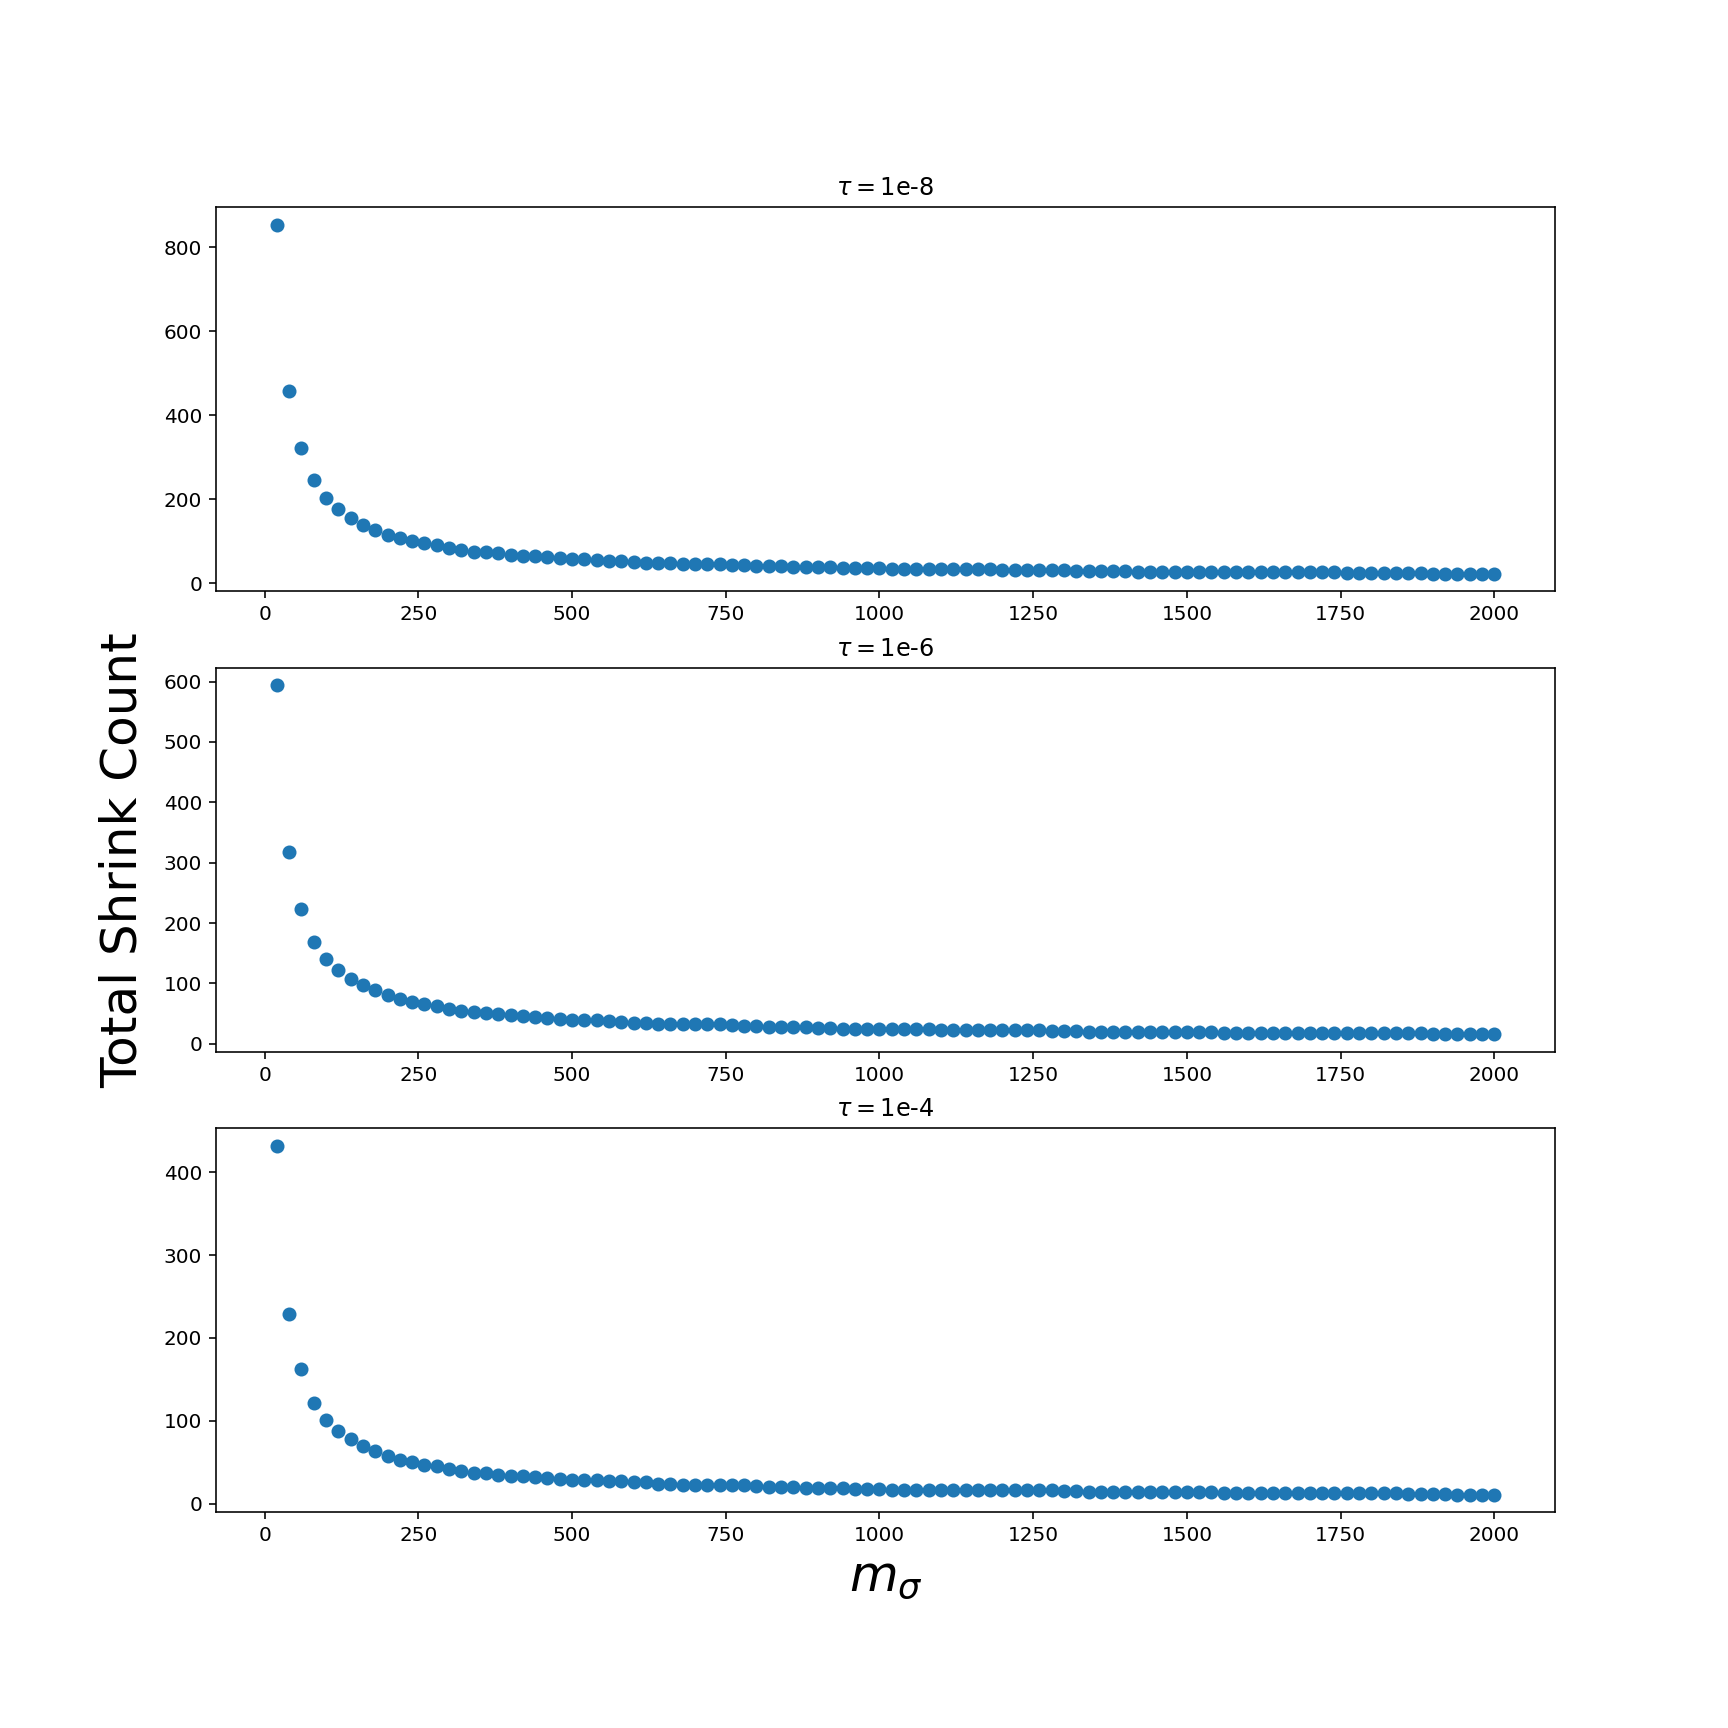

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [21]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['NShrink'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total Shrink Count",25)
plt.show()

<IPython.core.display.Javascript object>


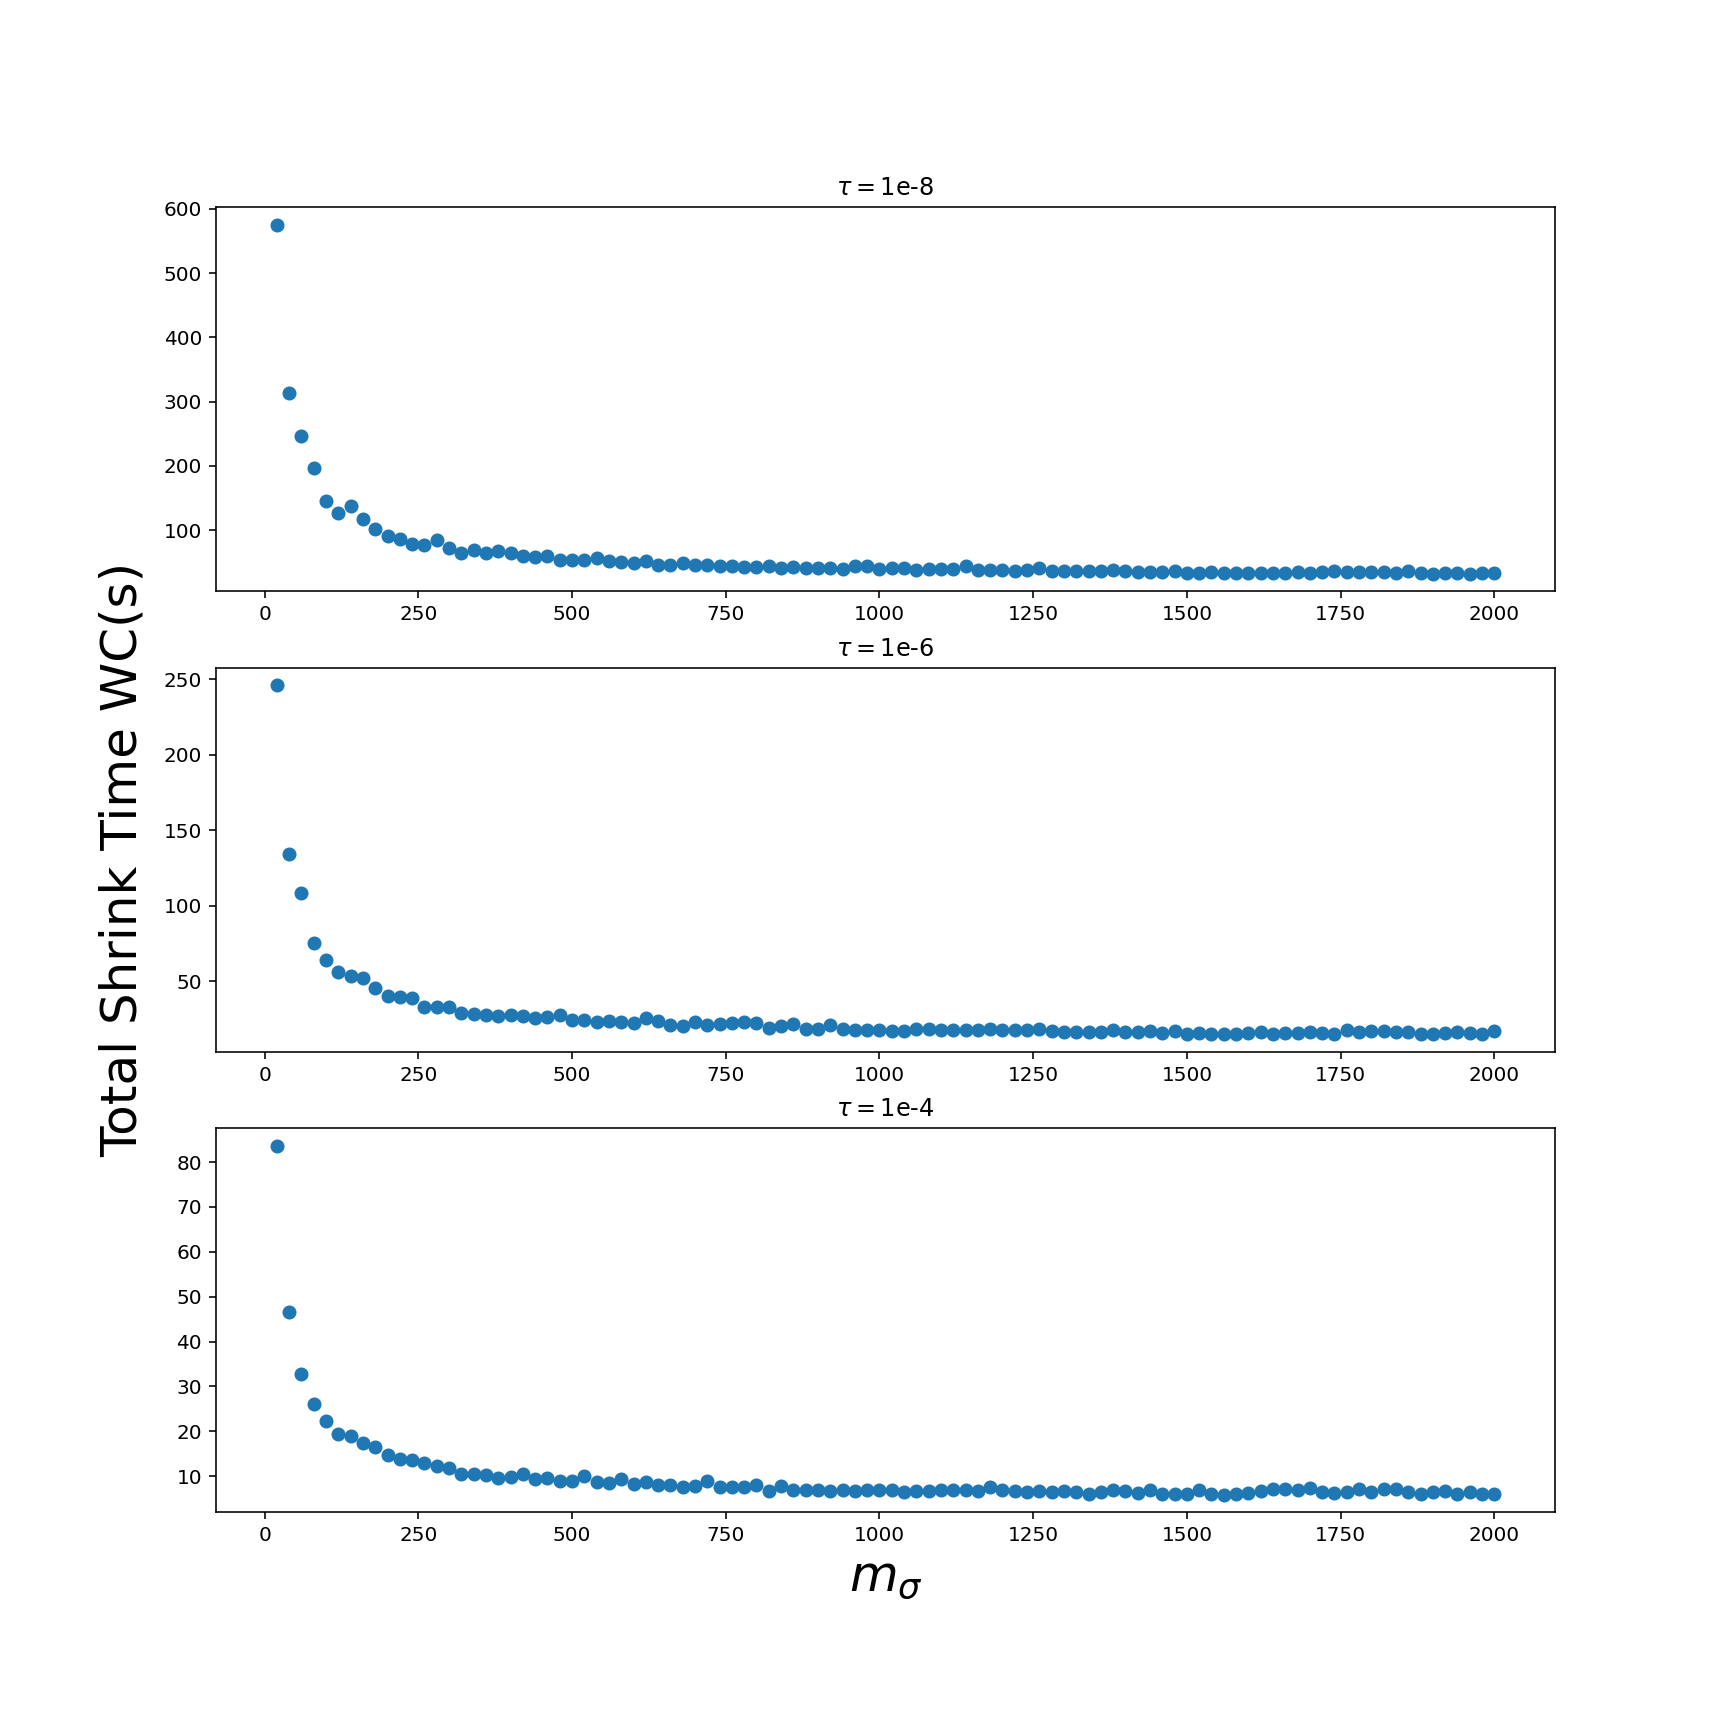

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [22]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['TShrink'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total Shrink Time WC(s)",25)
plt.show()

<IPython.core.display.Javascript object>


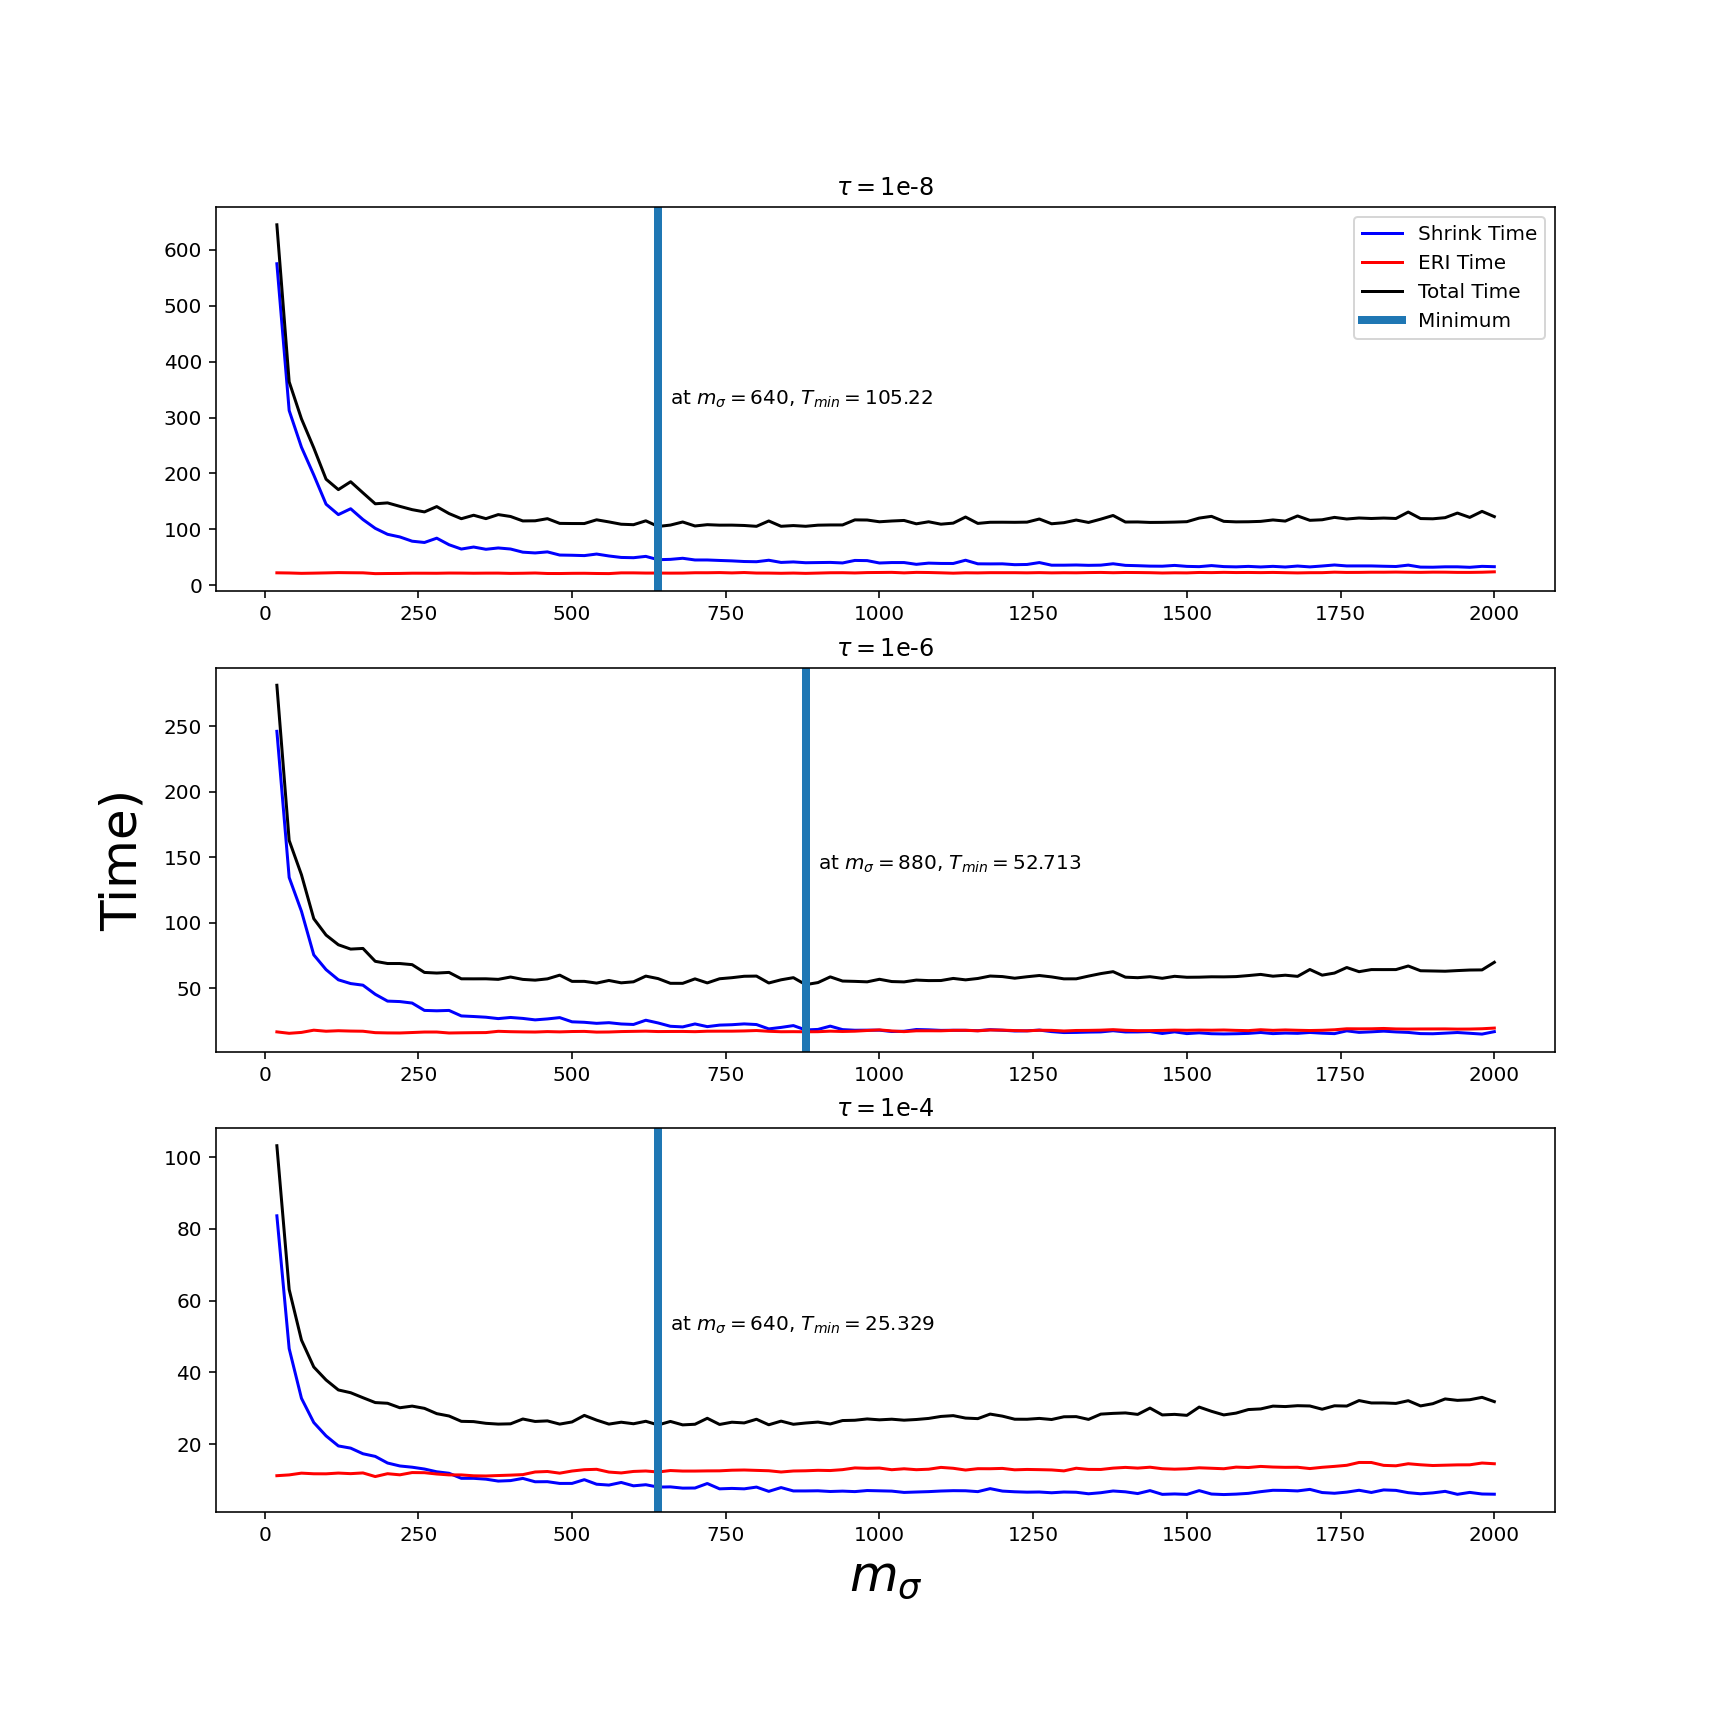

<ipython-input-2-b5ddb0f08091>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes = bboxes.inverse_transformed(f.transFigure)


In [32]:
sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1_list = []
    TShrink_list = []
    T1ERI_list = []
    for maxqual in maxquals:
        T1_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1'])
        TShrink_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['TShrink'])
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1ERI_WC'])
        
    ax[i].plot(maxquals,TShrink_list,'-b',label='Shrink Time')
    ax[i].plot(maxquals,T1ERI_list,'-r',label='ERI Time')
    ax[i].plot(maxquals,T1_list,'-k',label='Total Time')
    ax[i].set_title(r"$ \tau=$" + tau)
    
    min_val, min_idx = min((val, idx) for (idx, val) in enumerate(T1_list))
    ax[i].axvline(maxquals[min_idx], linewidth=4, color='#1f77b4',label='Minimum')
    ax[i].text(maxquals[min_idx]+20, 0.5 * np.max( np.array(T1_list) ), 
               'at $m_{\sigma}=$'+str(maxquals[min_idx])+', $T_{min}=$'+str(min_val))
    ax[0].legend(loc='upper right')

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Time)",25)
plt.show()

In [24]:
T1ERI_list

[11.188,
 11.408,
 11.9,
 11.724,
 11.71,
 11.92,
 11.759,
 11.959,
 10.947,
 11.744,
 11.429,
 12.061,
 12.024,
 11.657,
 11.41,
 11.405,
 11.158,
 11.107,
 11.231,
 11.344,
 11.487,
 12.223,
 12.357,
 11.893,
 12.489,
 12.859,
 12.967,
 12.198,
 11.958,
 12.373,
 12.501,
 12.214,
 12.627,
 12.477,
 12.478,
 12.526,
 12.544,
 12.717,
 12.775,
 12.667,
 12.566,
 12.218,
 12.498,
 12.558,
 12.688,
 12.624,
 12.873,
 13.355,
 13.248,
 13.317,
 12.855,
 13.118,
 12.86,
 12.992,
 13.502,
 13.254,
 12.763,
 13.14,
 13.124,
 13.219,
 12.827,
 12.93,
 12.872,
 12.794,
 12.529,
 13.268,
 12.943,
 12.923,
 13.298,
 13.501,
 13.302,
 13.552,
 13.134,
 13.006,
 13.116,
 13.389,
 13.261,
 13.124,
 13.579,
 13.465,
 13.772,
 13.598,
 13.516,
 13.541,
 13.175,
 13.526,
 13.783,
 14.085,
 14.877,
 14.867,
 14.066,
 13.948,
 14.521,
 14.23,
 14.024,
 14.116,
 14.206,
 14.221,
 14.72,
 14.517]

### 1.2 Examine the trend during the cholesky decomposition

###### To make the trends more clear, we choose sigma to be 0, and only use msigma to control the batch size

#### 1.2.1 Define functions to plot trend

In [35]:
def plot_ERI_size(data, tau, sigma, msigma):
    ERI_progress = data[tau,sigma,msigma]['ERI_vec']
    x = np.arange(1,len(ERI_progress)+1,1)
    plt.plot(x,ERI_progress)
    plt.show()

<IPython.core.display.Javascript object>


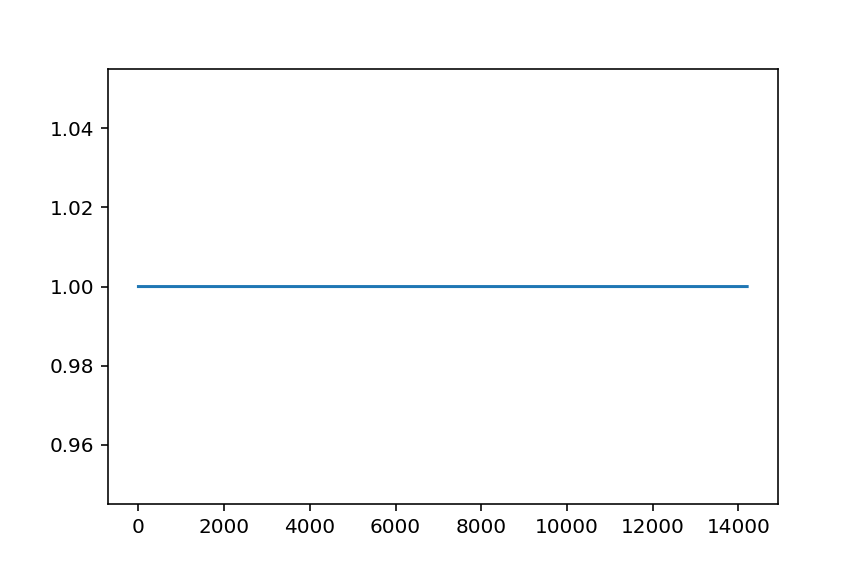

In [39]:
plot_ERI_size(Au14_Progress,'1e-8','1',1)

<IPython.core.display.Javascript object>


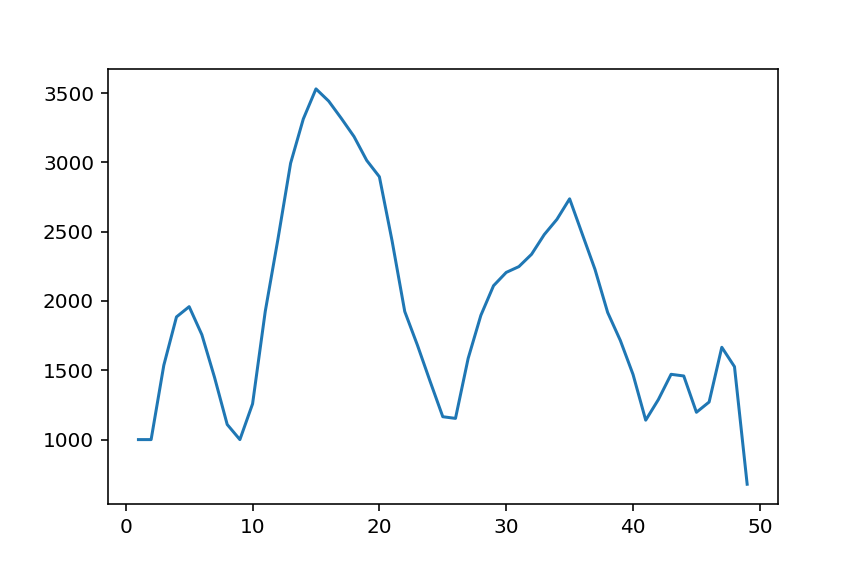

In [40]:
plot_ERI_size(Au14_Progress,'1e-8','1e-2',1000)

In [ ]:
#### Now set $\sigma$ to 0 and investigate the effect of $m_{\sigma}$

# Construct the name of the output files 
root = '/Users/aodongliu/LiGroup/cholesky/study_param/Au14/libint_seg/set_sigma_to_0/'
system = 'Au14'
basis = 'sto3g'
integral_engine = 'libint'
contraction_type = 's'
taus = ['1e-8', '1e-6', '1e-4'] 
sigma = 0
maxquals = np.arange(20,2020,20)

Au14_S0_Total = {}
Au14_S0_Progress = {}

for tau in taus:
    for maxqual in maxquals:

        fname = root + system

        fname += '_%s_%s%s' % (basis,integral_engine,contraction_type)

        fname += '_t%s_s%s_m%d' % (tau,sigma,maxqual)

        fname += '.out'

        print(fname)

        Au14_S0_Progress[(tau,sigma,maxqual)], Au14_S0_Total[(tau,sigma,maxqual)] = parseOutput(fname)


sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "T1 WC(s)",25)
plt.show()


sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['N1ERI'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Count",25)
plt.show()

sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1ERI_AllThreads'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Time All Threads(s)",25)
plt.show()

sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['T1ERI_WC'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total ERI Time WC(s)",25)
plt.show()

sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['NShrink'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total Shrink Count",25)
plt.show()

sigma = 0

fig, ax = plt.subplots(3,1,figsize=(12,12))

for i in range(3):
    tau = taus[i]
    T1ERI_list = []
    for maxqual in maxquals:
        T1ERI_list.append(Au14_S0_Total[(tau,sigma,maxqual)]['TShrink'])
        
        
    ax[i].scatter(maxquals,T1ERI_list)
    ax[i].set_title(r"$ \tau=$" + tau)

plt.xlabel("$m_{\sigma}$",fontsize=25)
set_shared_ylabel((ax[0], ax[1], ax[2]), "Total Shrink Time WC(s)",25)
plt.show()





























### 1.2 Examine the trend during the cholesky decomposition

###### To make the trends more clear, we choose sigma to be 0, and only use msigma to control the batch size

#### 1.2.1 Define functions to plot trend

def plot_ERI_size(data, tau, sigma, msigma):
    ERI_progress = data[tau,sigma,msigma]['ERI_vec']
    x = np.arange(1,len(ERI_progress)+1,1)
    plt.plot(x,ERI_progress)
    plt.show()

plot_ERI_size(Au14_Progress,'1e-8','1',1)

plot_ERI_size(Au14_Progress,'1e-8','1e-2',1000)